In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats

from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
%load_ext watermark
az.rcParams['stats.credible_interval'] = 0.89

#### Code 4.1

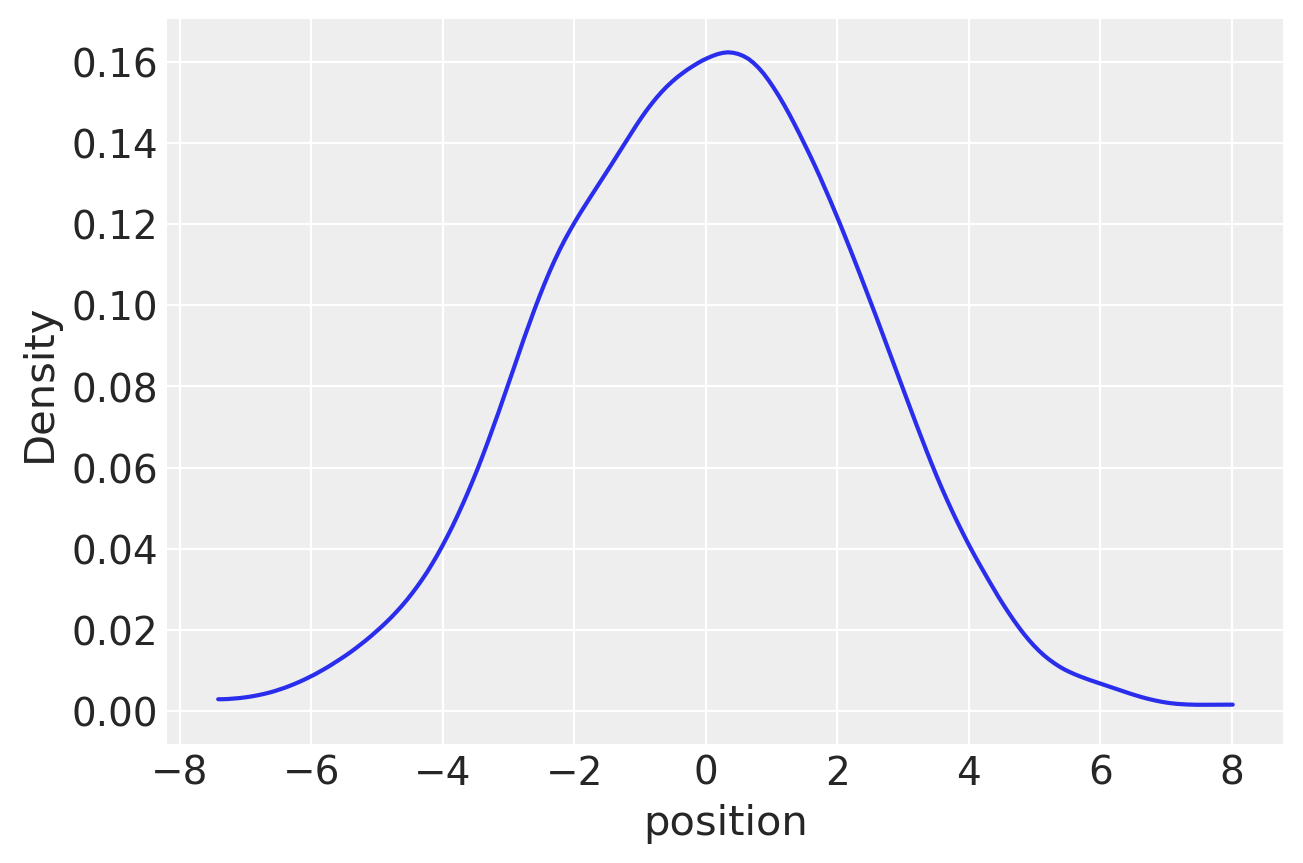

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

#### Code 4.2 and 4.3

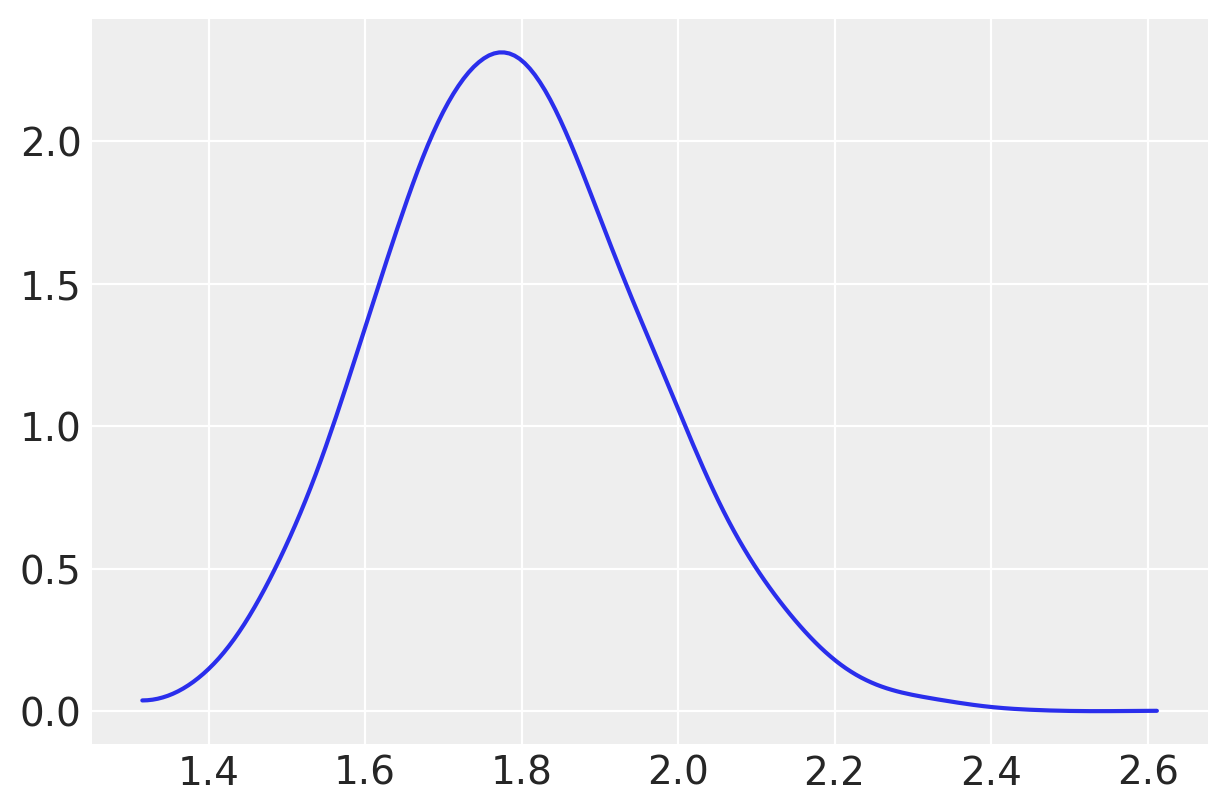

In [4]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

#### Code 4.4

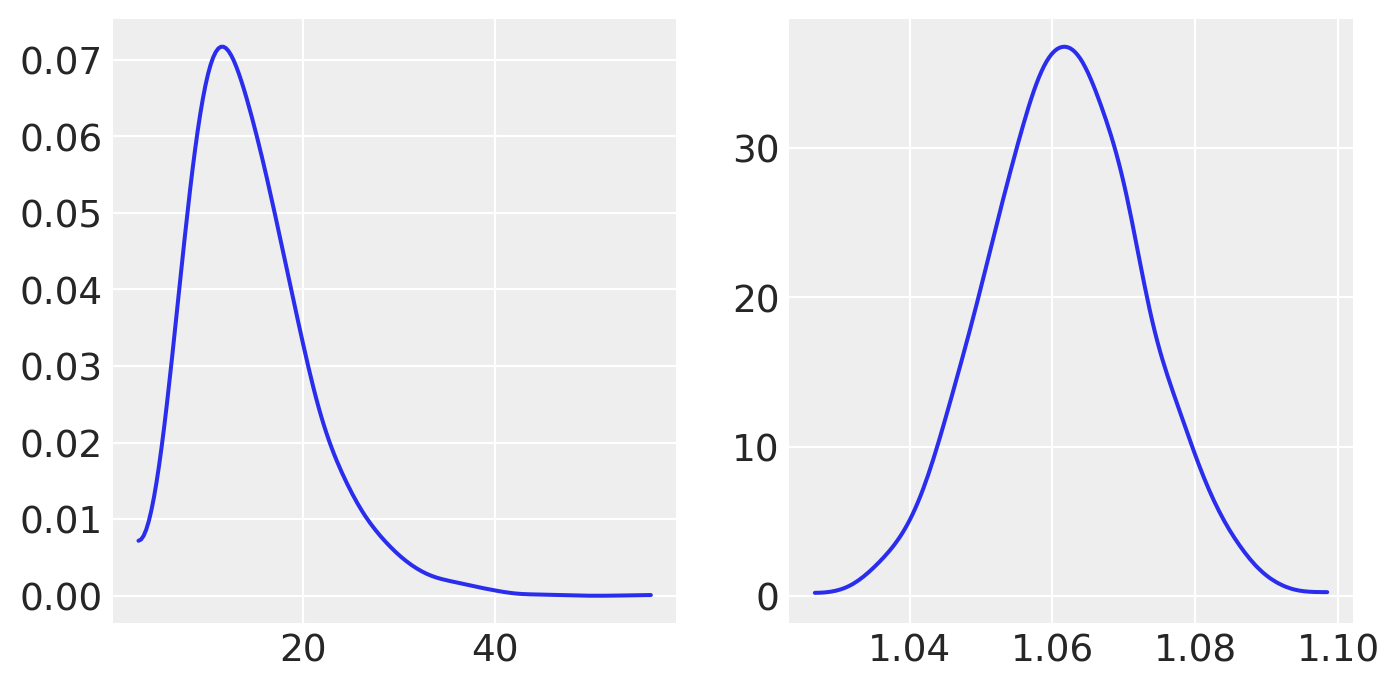

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

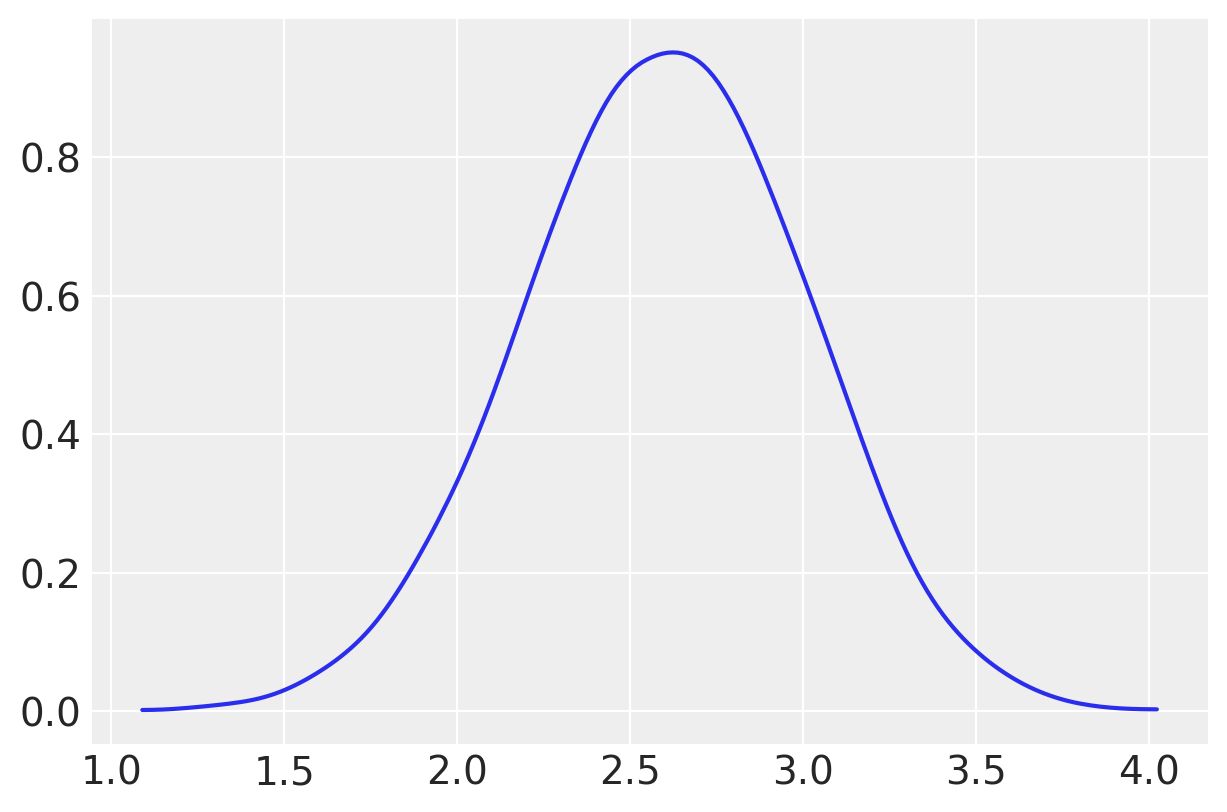

In [6]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

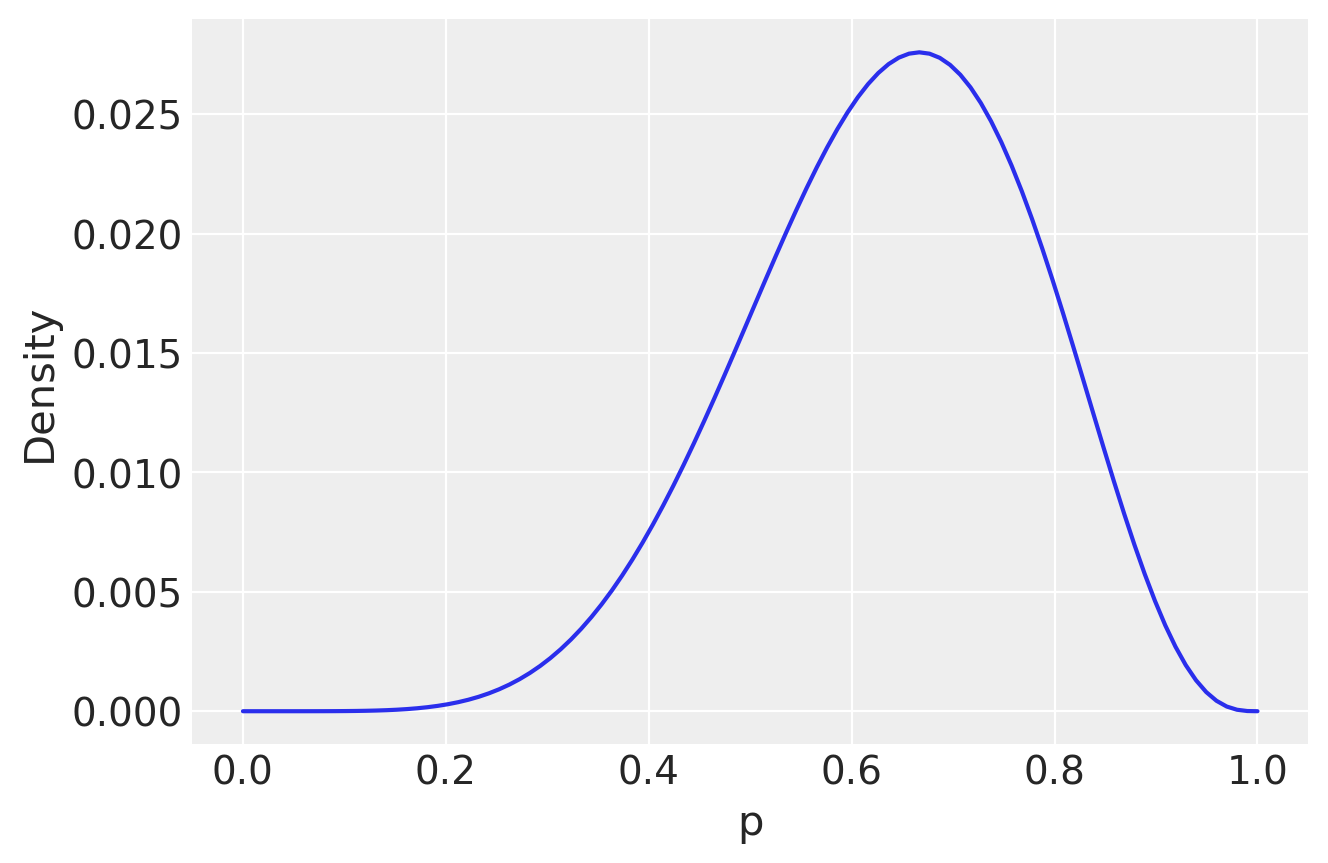

In [7]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * \
    stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

#### Code 4.7 and 4.8

In [8]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

In [9]:
az.summary(d.to_dict(orient="list"), kind='stats')

mean      sd  hpd_3%  hpd_97%
height  138.264  27.602  81.585  172.999
weight   35.611  14.719   7.201   55.282
age      29.344  20.747   0.000   65.300
male      0.472   0.500   0.000    1.000

#### Code 4.10

In [10]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [11]:
d2 = d[d.age >= 18]

#### Code 4.12

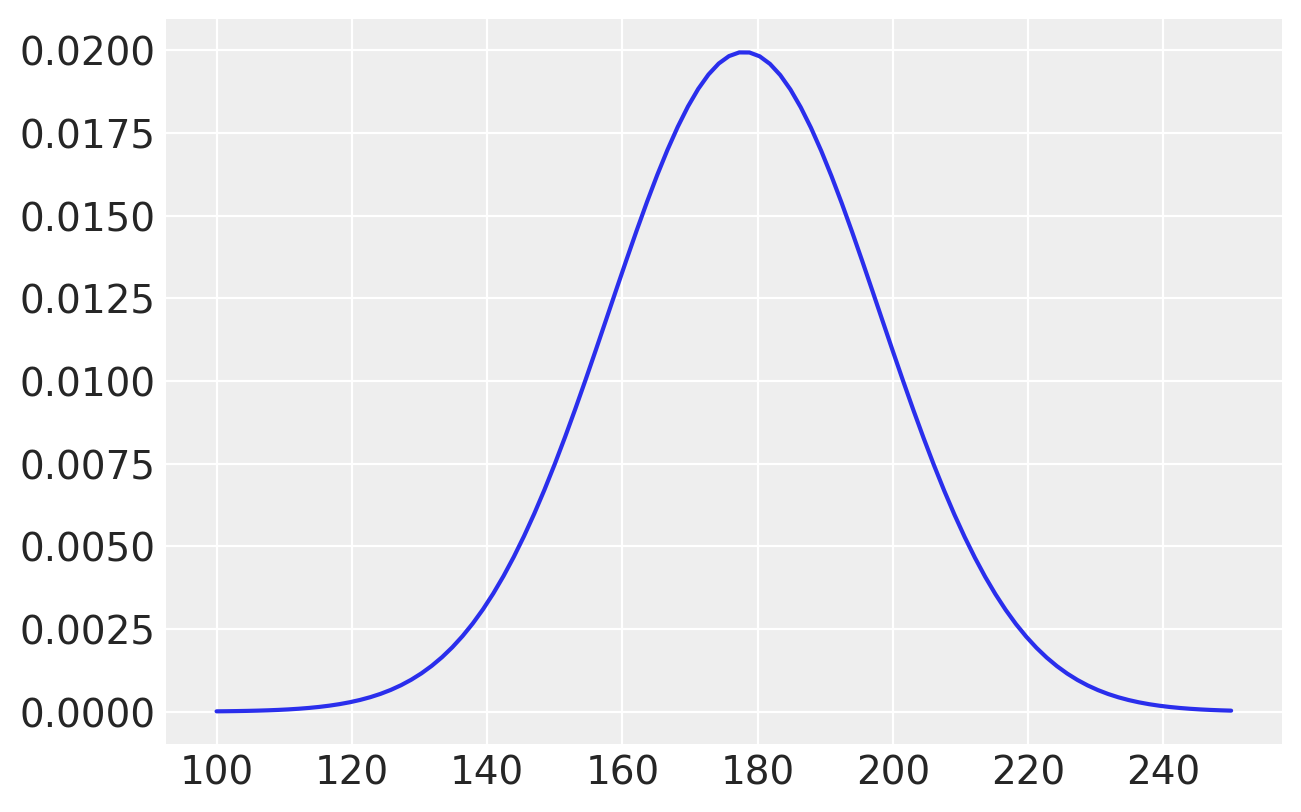

In [12]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13

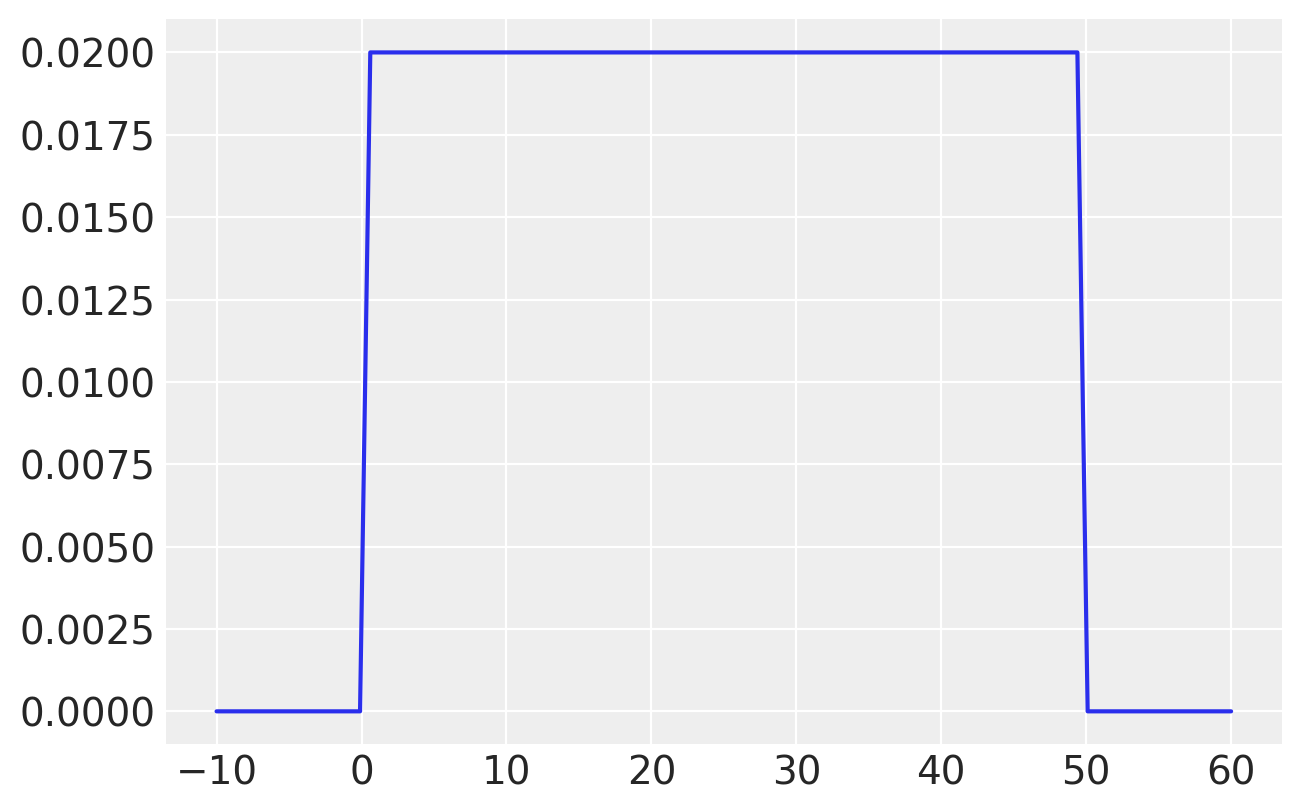

In [13]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14

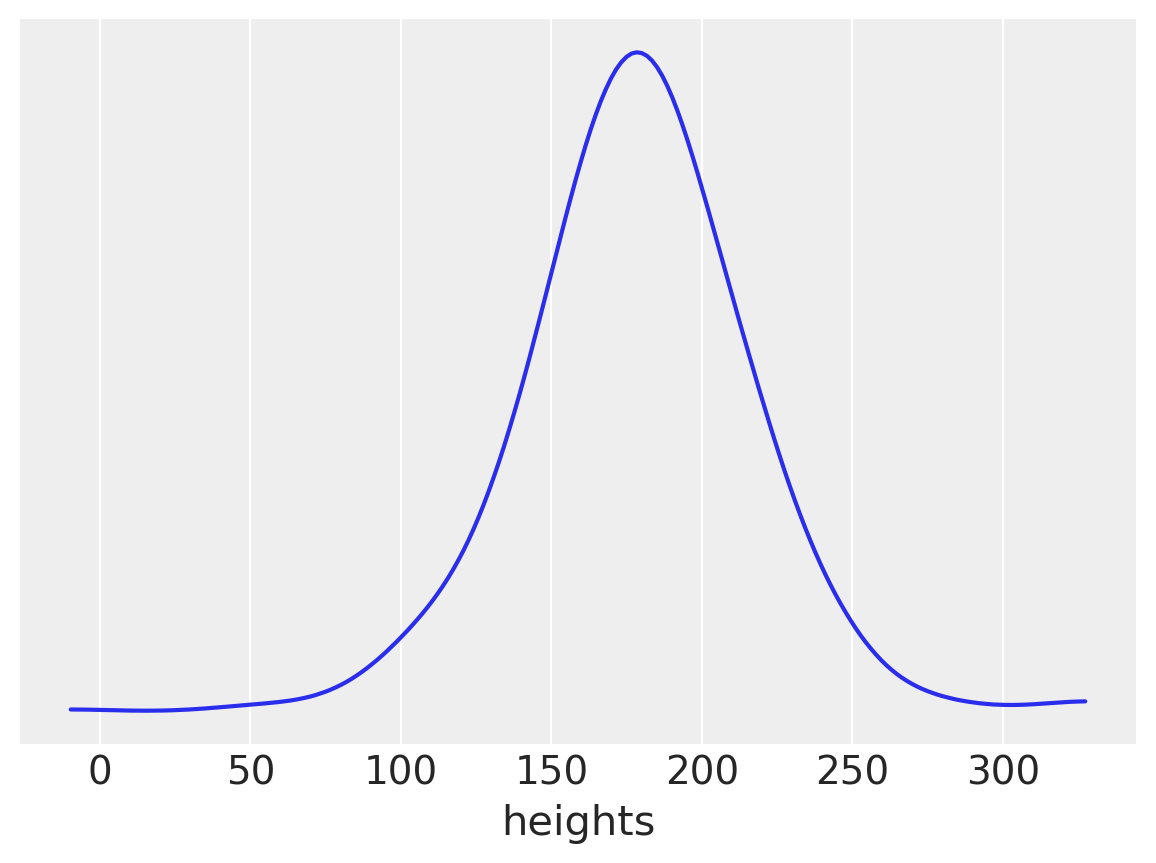

In [14]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

#### Code 4.15

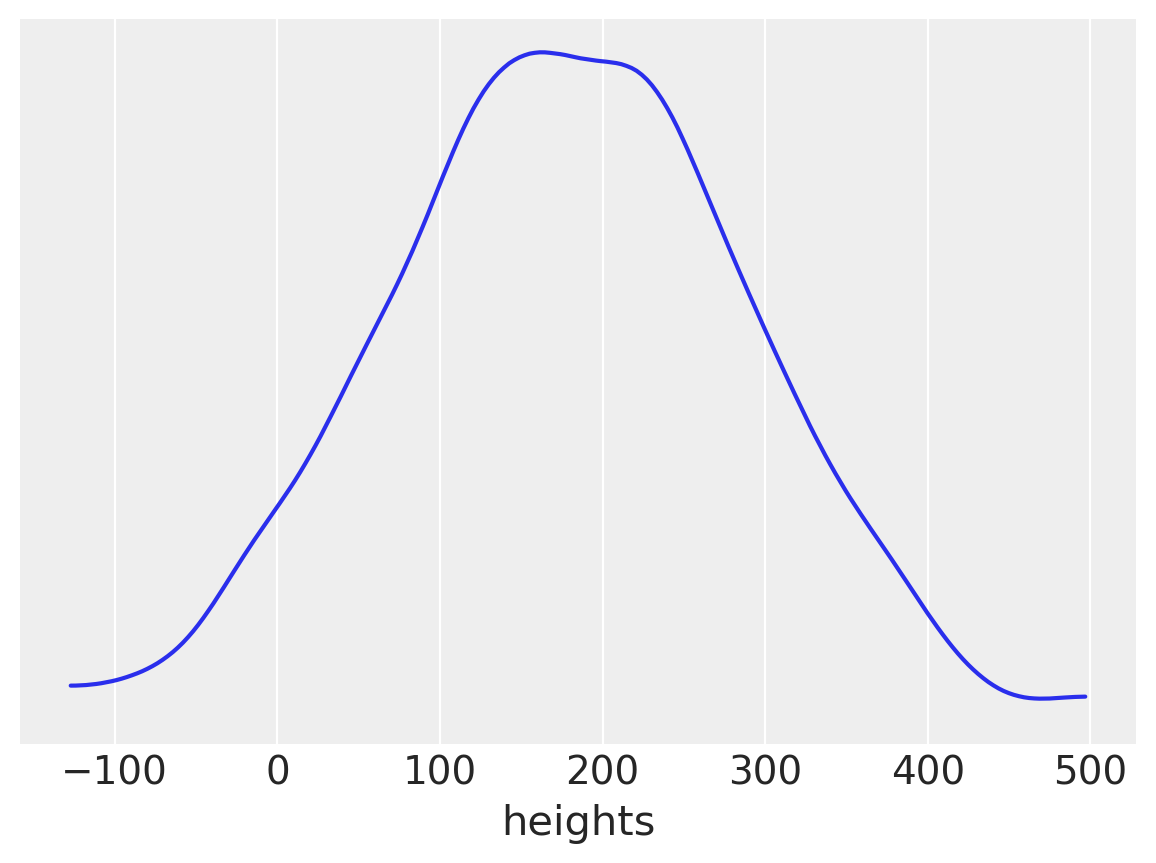

In [15]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

#### Code 4.16

In [16]:
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:, 0]
                                    [i], scale=post[:, 1][i])) for i in range(len(post))]

post_prod = (likelihood +
             stats.norm.logpdf(post[:, 0], loc=178, scale=20) +
             stats.uniform.logpdf(post[:, 1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.17

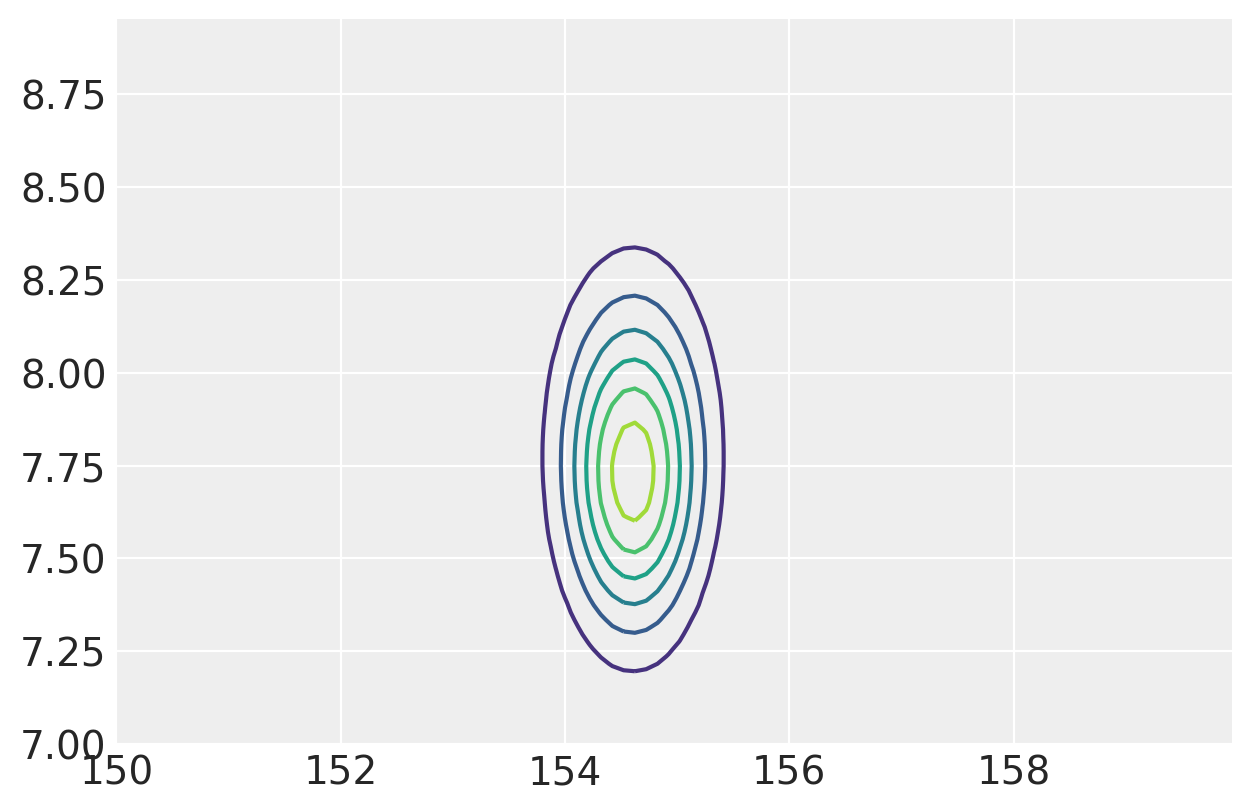

In [17]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

#### Code 4.18

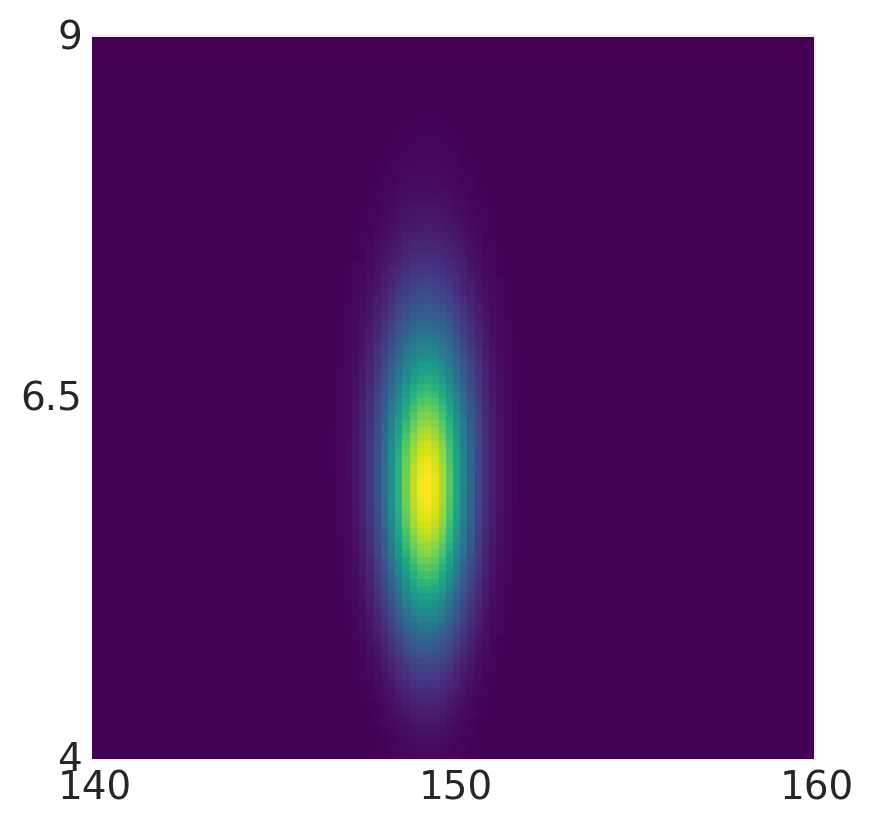

In [18]:
_, ax = plt.subplots()
ax.imshow(zi, origin='bottom')
ax.set_xticks([0, 50, 100])
ax.set_xticklabels([140, 150, 160])
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([4, 6.5, 9])
ax.grid(False);

#### Code 4.19 and 4.20

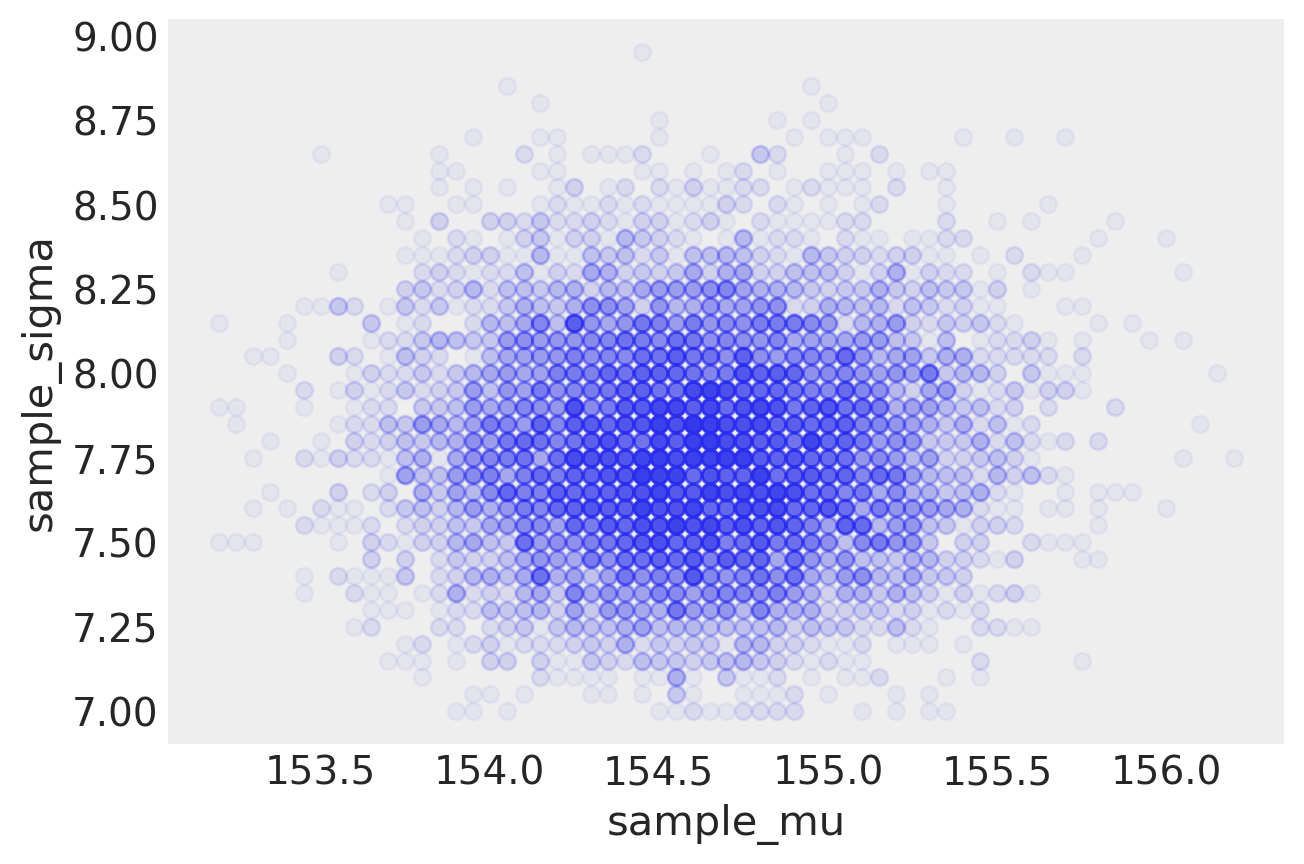

In [19]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True,
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma');

#### Code 4.21

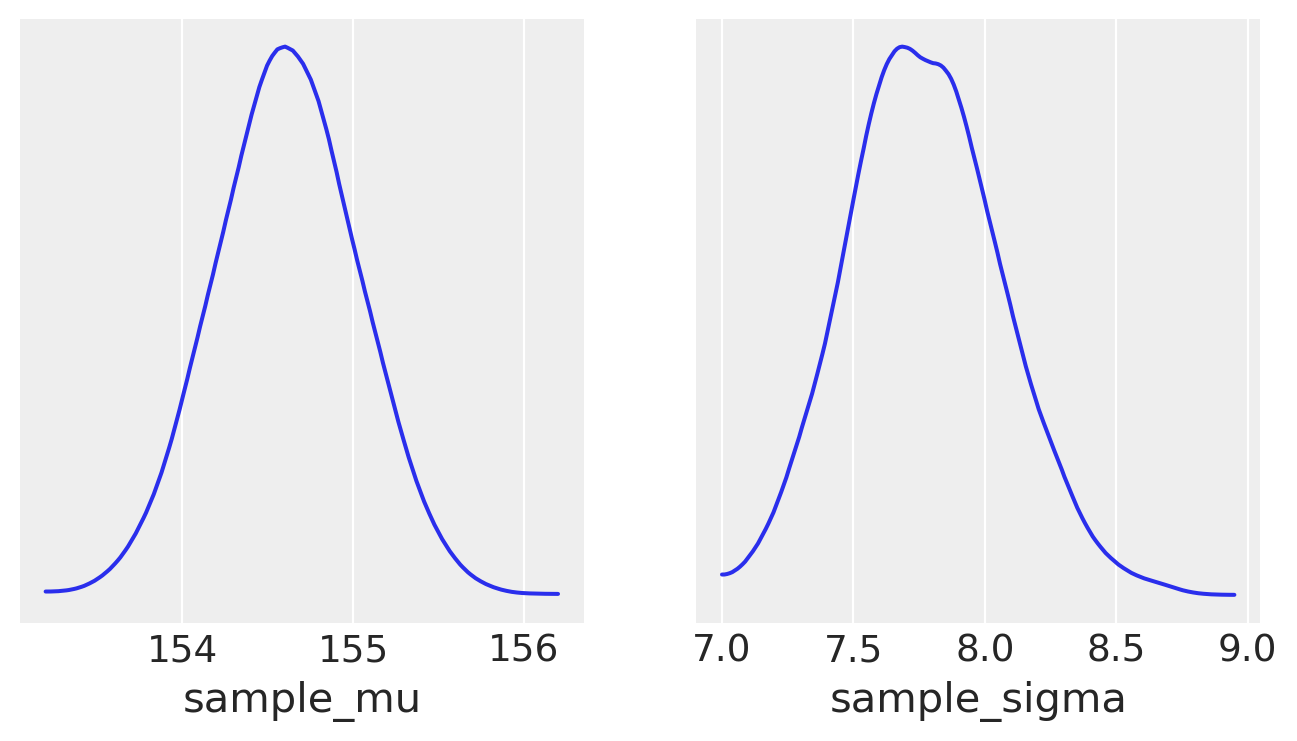

In [20]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

#### Code 4.22

In [21]:
az.hpd(sample_mu), az.hpd(sample_sigma)

(array([153.9, 155.4]), array([7.3 , 8.35]))

#### Code 4.23 and  4.24

In [22]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post2[:, 0][i],
                                     scale=post2[:, 1][i])) for i in range(len(post2))]

post_prod2 = (likelihood2 +
              stats.norm.logpdf(post2[:, 0], loc=178, scale=20) +
              stats.uniform.logpdf(post2[:, 1], loc=0, scale=50))

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(np.arange(len(post2)), size=10000, replace=True,
                                p=(post_prob2/post_prob2.sum()))
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

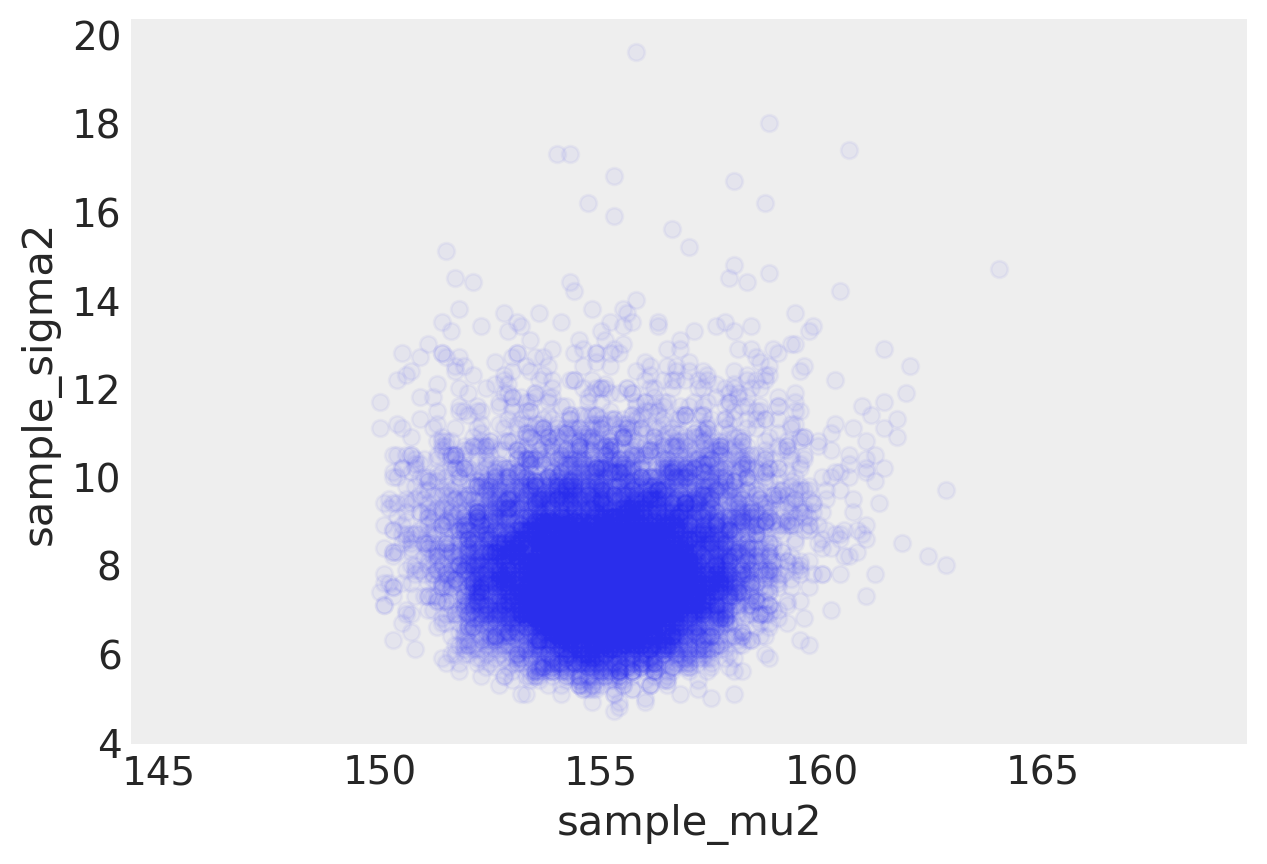

In [23]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2')
plt.ylabel('sample_sigma2')
plt.grid(False);

#### Code 4.25

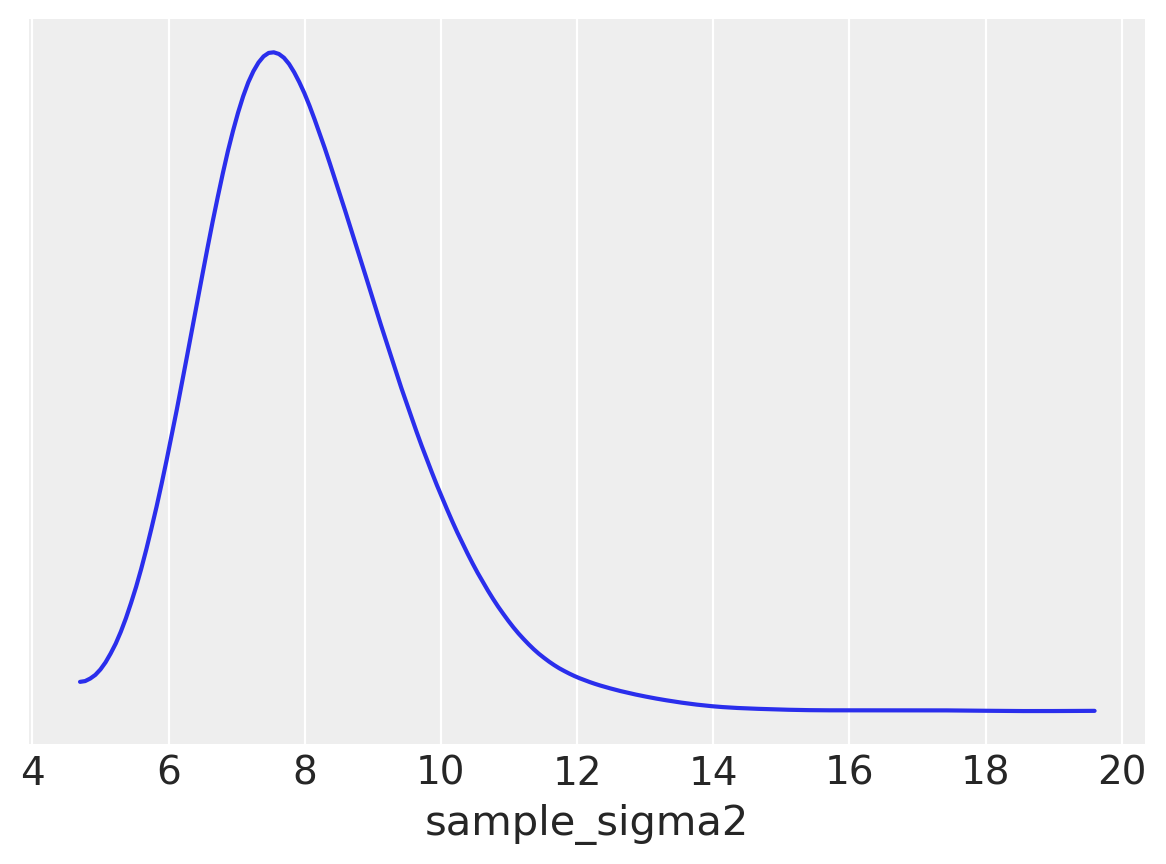

In [24]:
az.plot_kde(sample_sigma2)
plt.xlabel('sample_sigma2')
plt.yticks([]);

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10

In [25]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.27

In [26]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.28

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [27]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


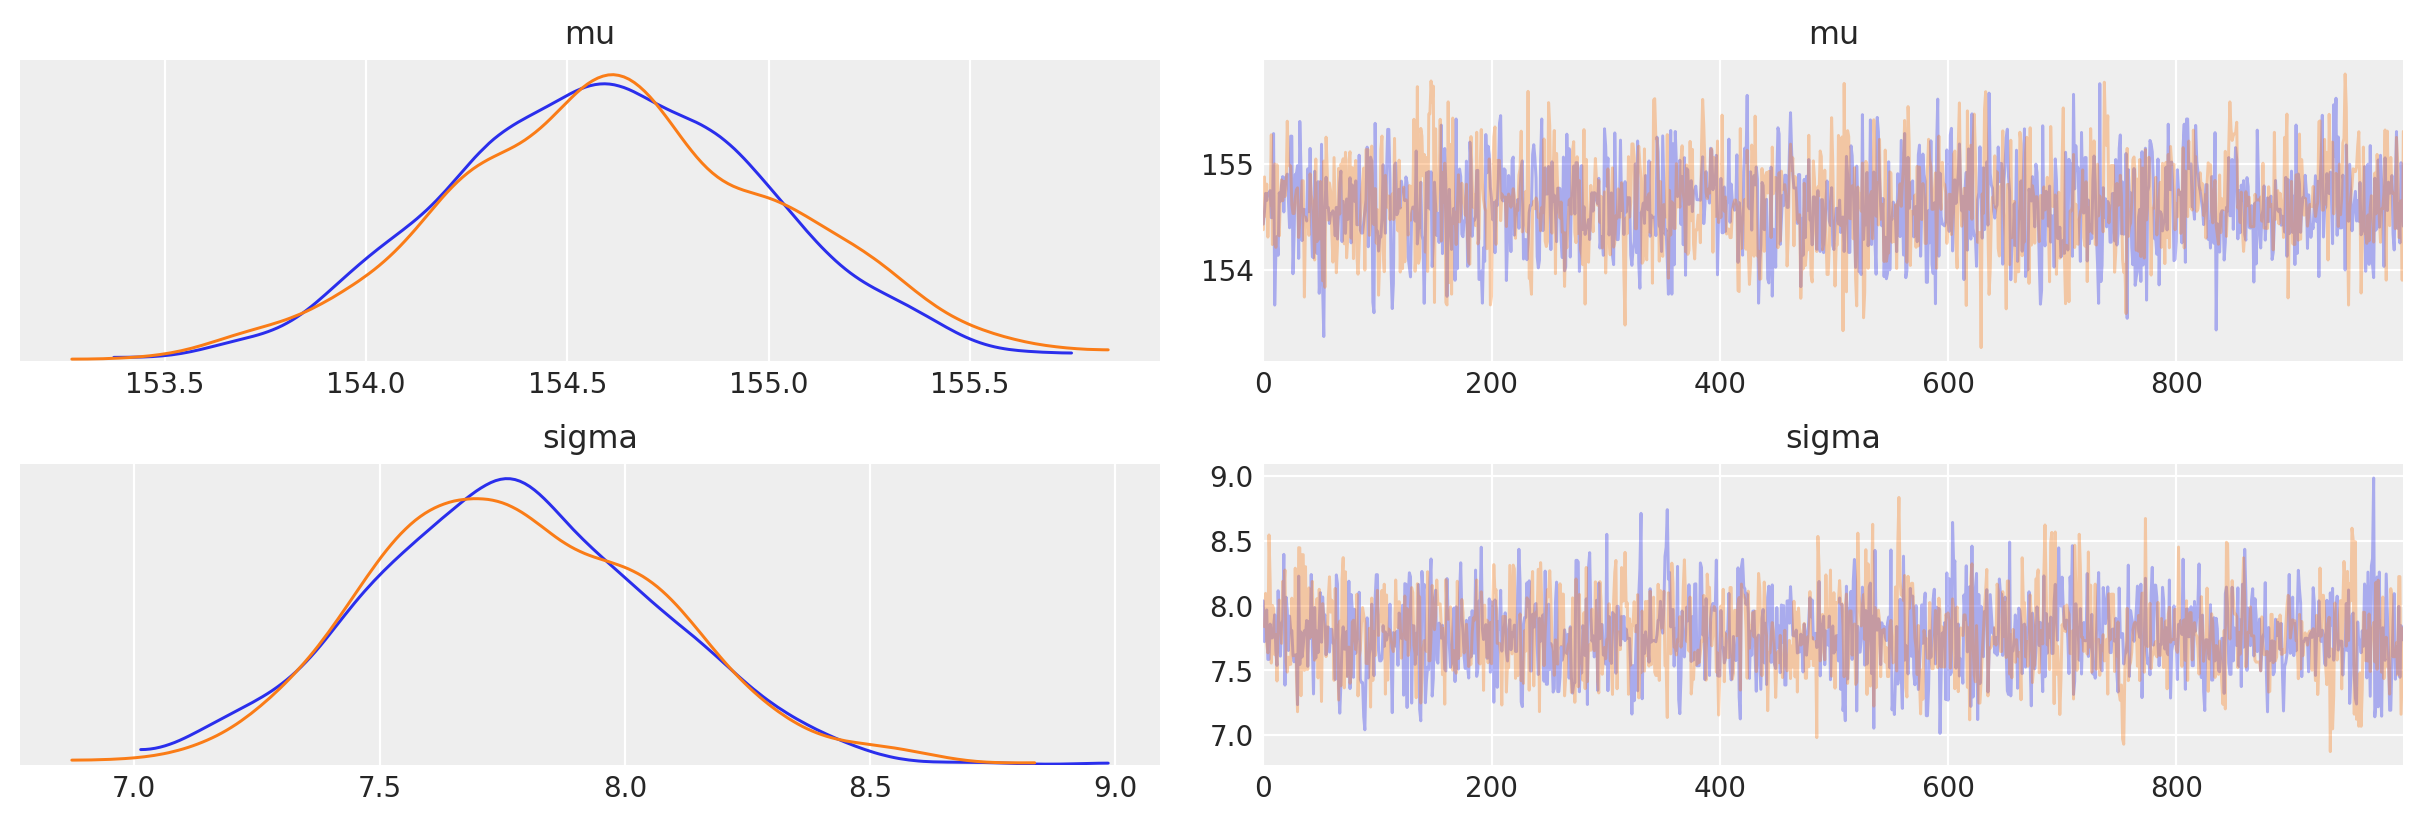

In [28]:
az.plot_trace(trace_4_1);  # this function lets you check the samples values

#### Code 4.29

In [29]:
az.summary(trace_4_1, round_to=2, kind='stats')

mean    sd  hpd_3%  hpd_97%
mu     154.61  0.41  153.87   155.37
sigma    7.77  0.29    7.24     8.32

#### Code 4.30

In [30]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


#### Code 4.31

In [31]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


mean    sd  hpd_3%  hpd_97%
mu     177.87  0.10  177.68   178.05
sigma   24.60  0.91   22.88    26.29

#### Code 4.32

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [32]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

mu     sigma
mu     0.173506 -0.000647
sigma -0.000647  0.089581

#### Code 4.33

In [33]:
np.diag(trace_df.cov())

array([0.17350635, 0.08958122])

In [34]:
trace_df.corr()

mu     sigma
mu     1.000000 -0.005191
sigma -0.005191  1.000000

#### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [35]:
trace_df.head()

mu     sigma
0  154.228165  7.534322
1  154.384016  7.616599
2  153.960932  7.869676
3  154.284885  8.094794
4  154.490030  7.540991

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [36]:
trace_4_1['sigma'][:10]

array([7.5343218 , 7.61659881, 7.86967638, 8.09479448, 7.54099062,
       7.25078344, 7.60280795, 7.54465177, 7.56471302, 8.11789371])

#### Code 4.35

In our case, this is the same we did in the code 4.27

In [37]:
az.summary(trace_4_1, round_to=2, kind='stats')

mean    sd  hpd_3%  hpd_97%
mu     154.61  0.42  153.85   155.40
sigma    7.77  0.30    7.22     8.33

#### Code 4.36

In [38]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[154.27686233,   7.66367117],
       [155.24067088,   7.57817841],
       [154.93871149,   7.6504121 ],
       [154.42488668,   7.18486991],
       [154.76198063,   7.38263195],
       [154.12693485,   7.97946587],
       [154.89771446,   7.3710203 ],
       [154.35566826,   7.72632894],
       [154.8034419 ,   7.64404149],
       [154.46981648,   7.73800997]])

#### Code 4.37

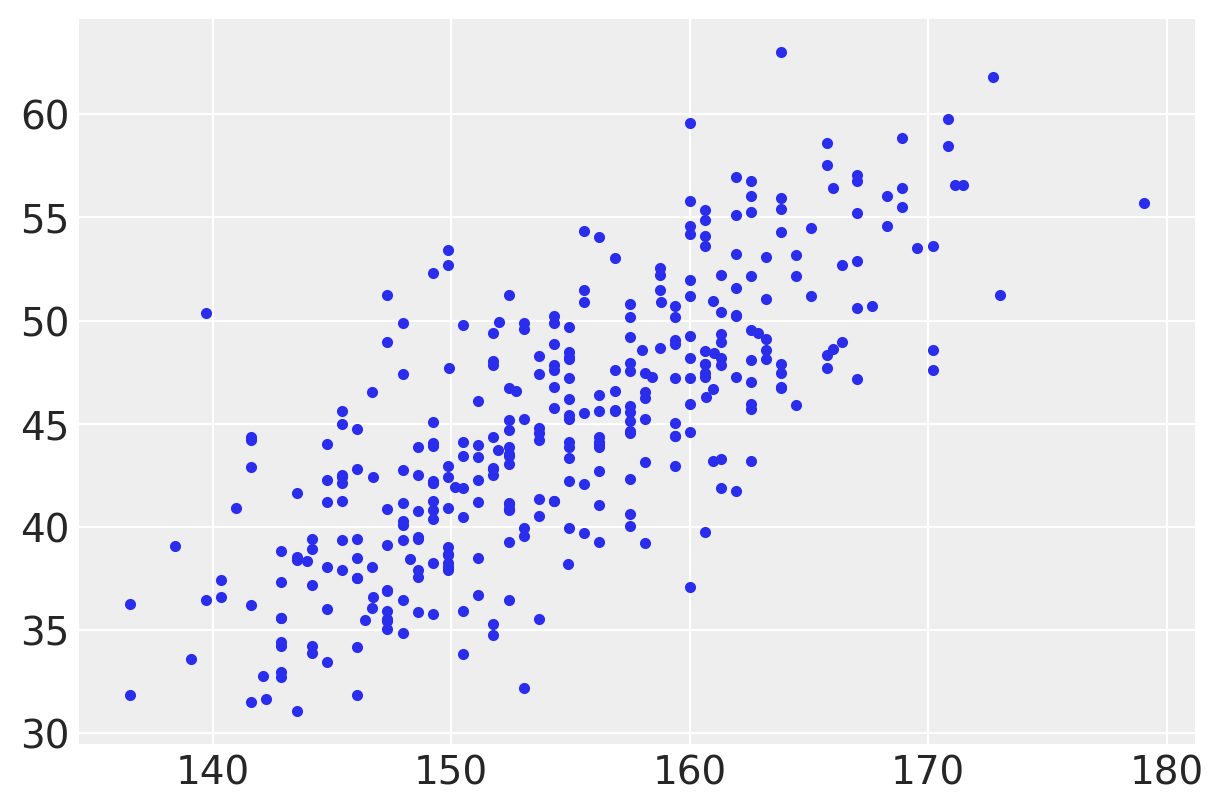

In [39]:
plt.plot(d2.height, d2.weight, '.');

#### Code 4.38

In [40]:
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### Code 4.39 and 4.40

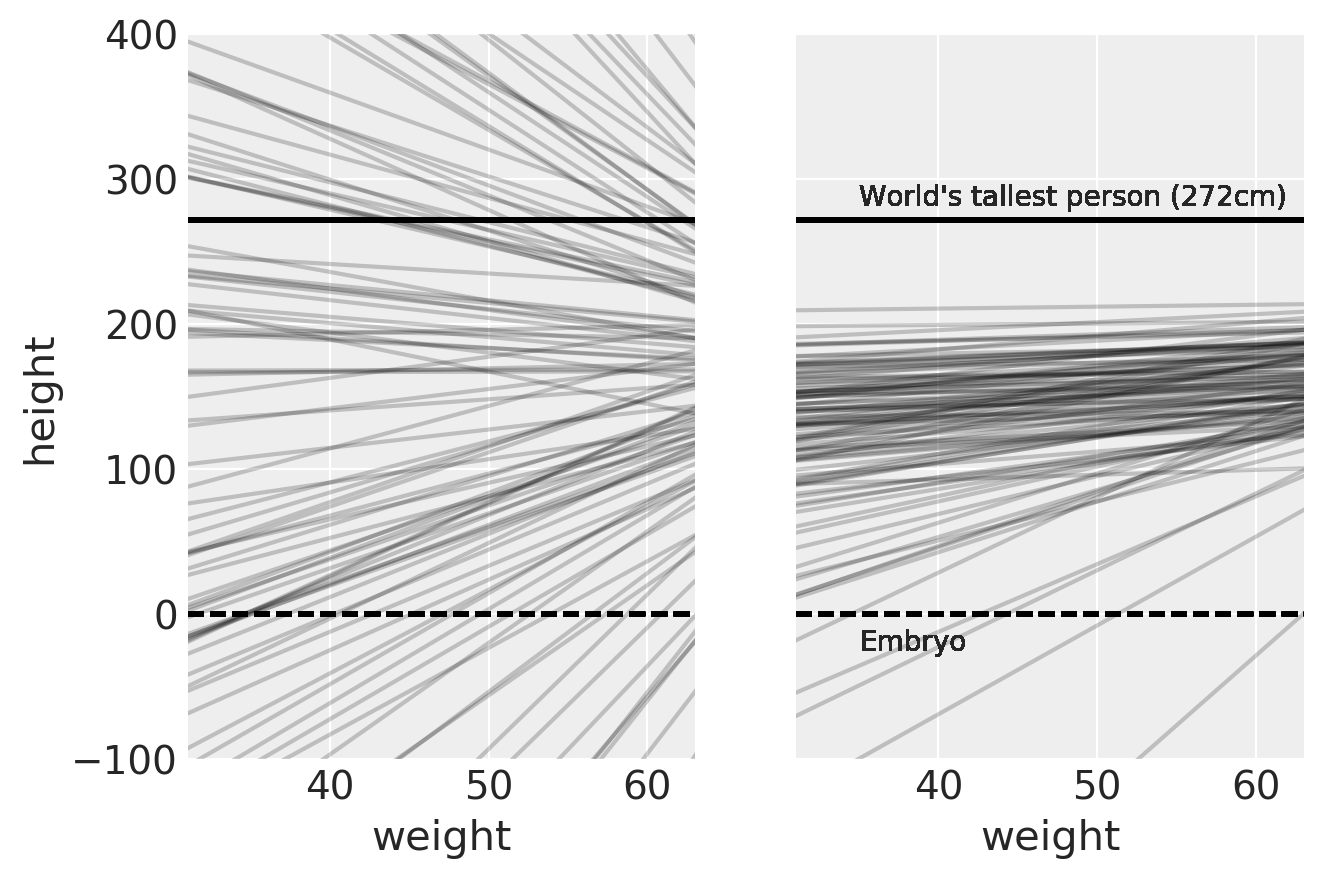

In [41]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
for i in range(N):
    ax[0].plot(a[i] + b[i]*(x - xbar), 'k', alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c='k', ls='--')
    ax[0].axhline(272, c='k')
    ax[0].set_xlabel('weight')
    ax[0].set_ylabel('height')

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b[i]*(x - xbar), 'k', alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c='k', ls='--', label='embryo')
    ax[1].axhline(272, c='k')
    ax[1].set_xlabel('weight')
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s='Embryo');

#### Code 4.42

In [42]:
with pm.Model() as m4_3:
    a = pm.Normal('a', mu=178, sd=20)
    b = pm.Lognormal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


In [43]:
with pm.Model() as m4_3b:
    a = pm.Normal('a', mu=178, sd=20)
    b = pm.Normal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = a + np.exp(b) * (d2.weight - xbar)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


#### Code 4.44

In [44]:
az.summary(trace_4_3, kind='stats')

mean     sd   hpd_3%  hpd_97%
a      154.611  0.281  154.126  155.176
b        0.904  0.040    0.832    0.982
sigma    5.098  0.192    4.759    5.475

#### Code 4.45

In [45]:
trace_4_3_df = pm.trace_to_dataframe(trace_4_3)
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.079 -0.001  0.001
b     -0.001  0.002 -0.000
sigma  0.001 -0.000  0.037

#### Code 4.46

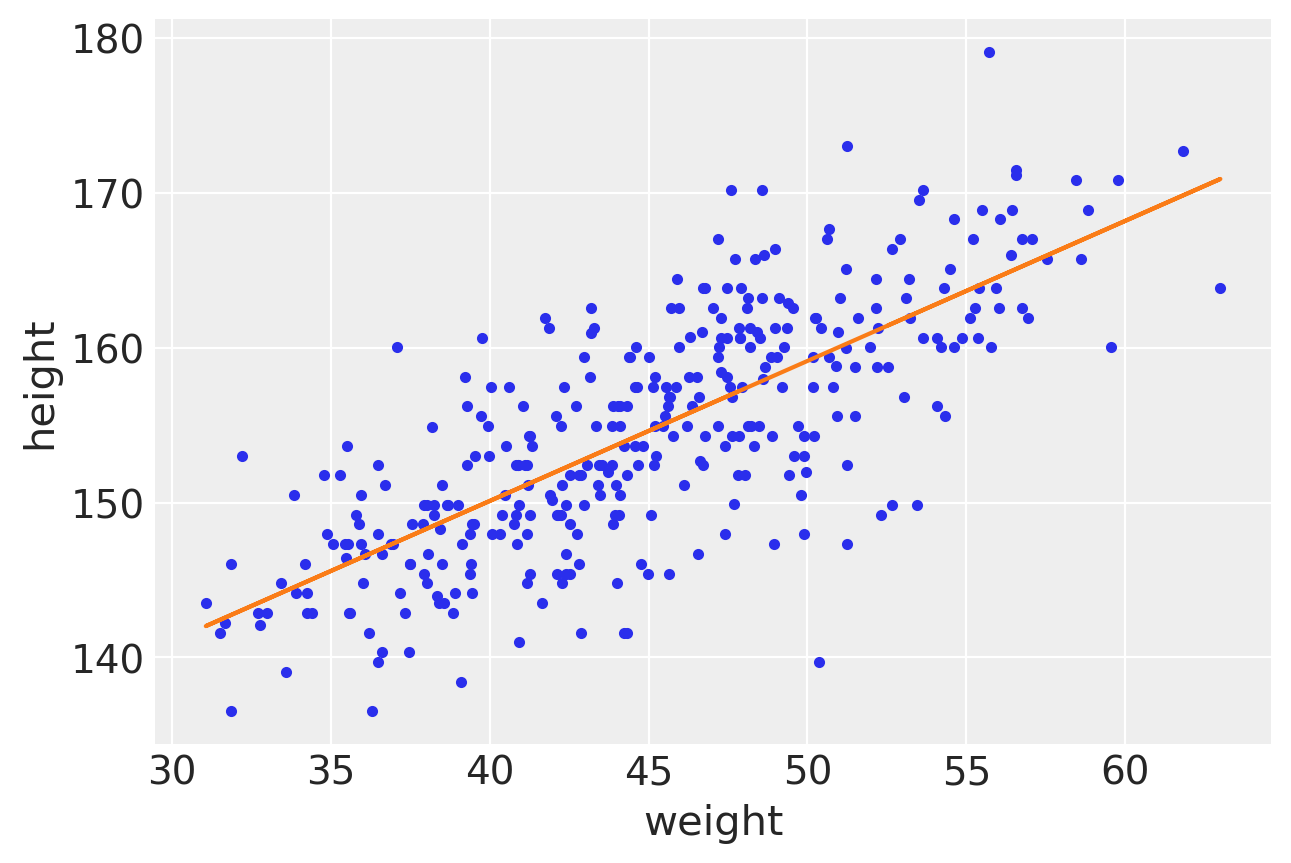

In [46]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['a'].mean() +
         trace_4_3['b'].mean() * (d2.weight - xbar))
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.47

In [47]:
trace_4_3_df.head(5)

a         b     sigma
0  154.256636  0.889309  4.915835
1  154.953658  0.930847  5.349857
2  153.916428  0.879771  5.010077
3  155.197554  0.928082  5.292316
4  154.302416  0.887257  5.500605

#### Code 4.48

In [48]:
N = [10, 50, 150, 352][0]
dN = d2[:N]
with pm.Model() as m_N:
    a = pm.Normal('a', mu=178, sd=100)
    b = pm.Lognormal('b', mu=0, sd=1)
    sigma = pm.Uniform('sigma', 0, 50)
    mu = pm.Deterministic('mu', a + b * (dN.weight - dN.weight.mean()))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=dN.height)
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


#### Code 4.49

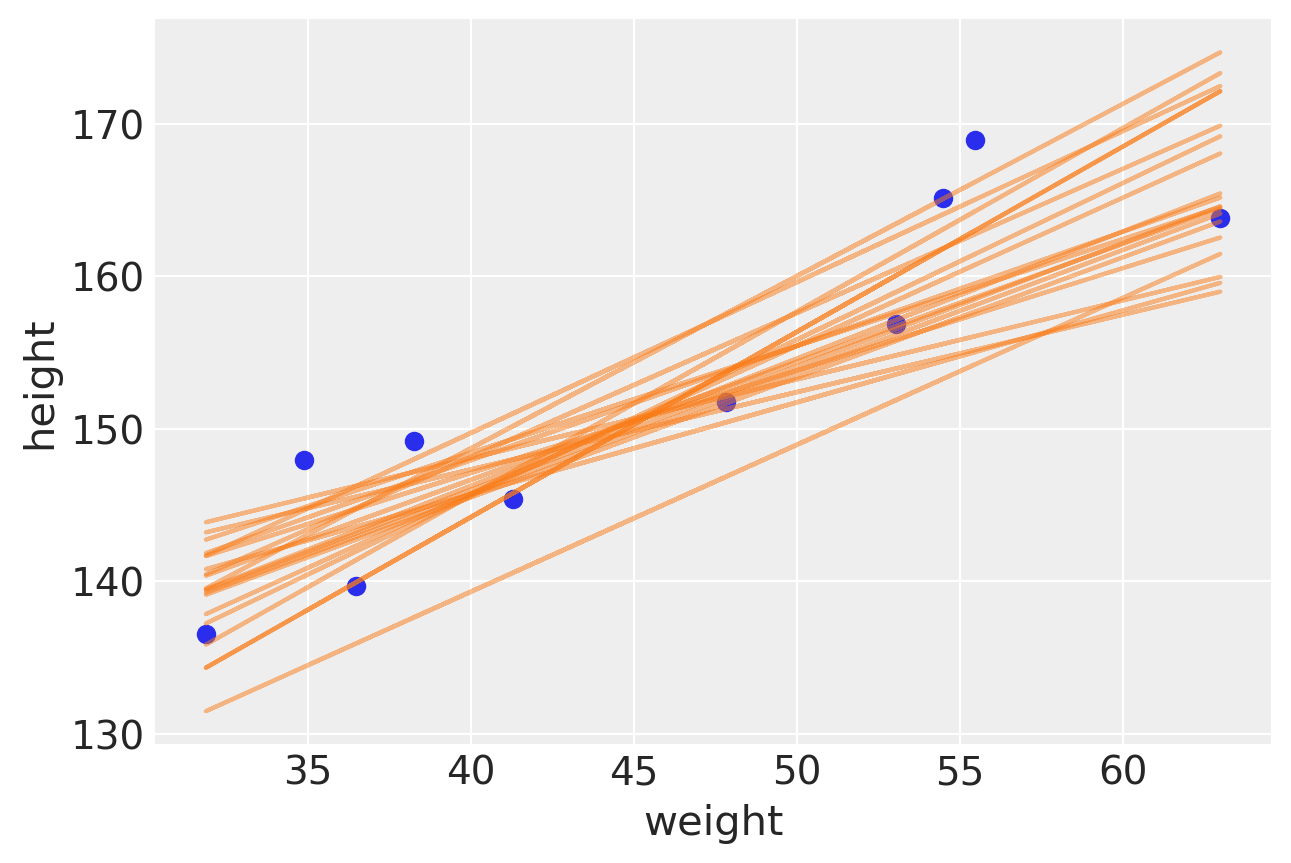

In [49]:
plt.plot(dN.weight, dN.height, 'C0o')
idxs = np.random.randint(len(trace_N), size=20)
for idx in idxs:
    plt.plot(dN.weight, trace_N['a'][idx] + trace_N['b'][idx]
             * (dN.weight - dN.weight.mean()), 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu` variable

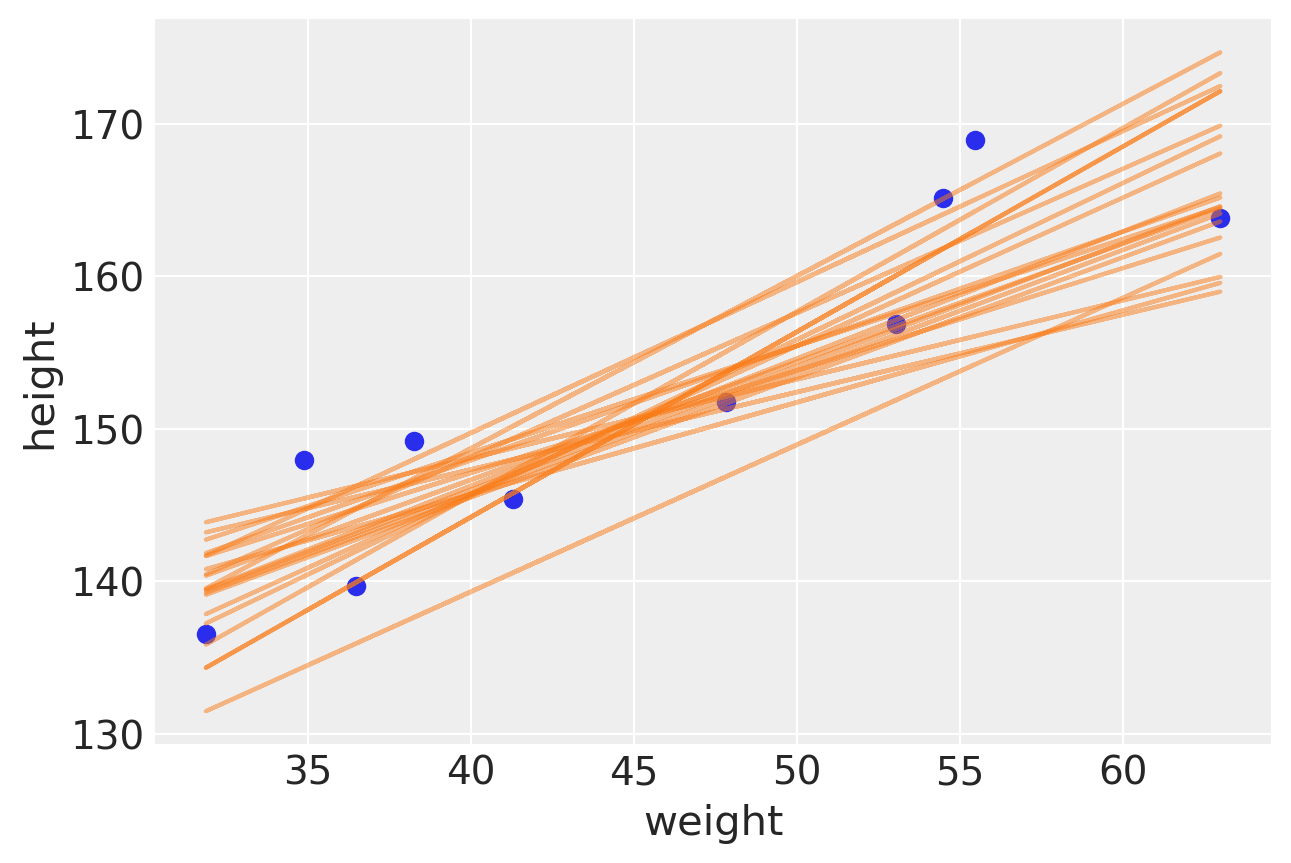

In [50]:
plt.plot(dN.weight, dN.height, 'C0o')
for idx in idxs:
    plt.plot(d2.weight[:N], trace_N['mu'][idx], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.50

In [51]:
mu_at_50 = trace_4_3['a'] + trace_4_3['b'] * (50 - d2.weight.mean())

#### Code 4.51

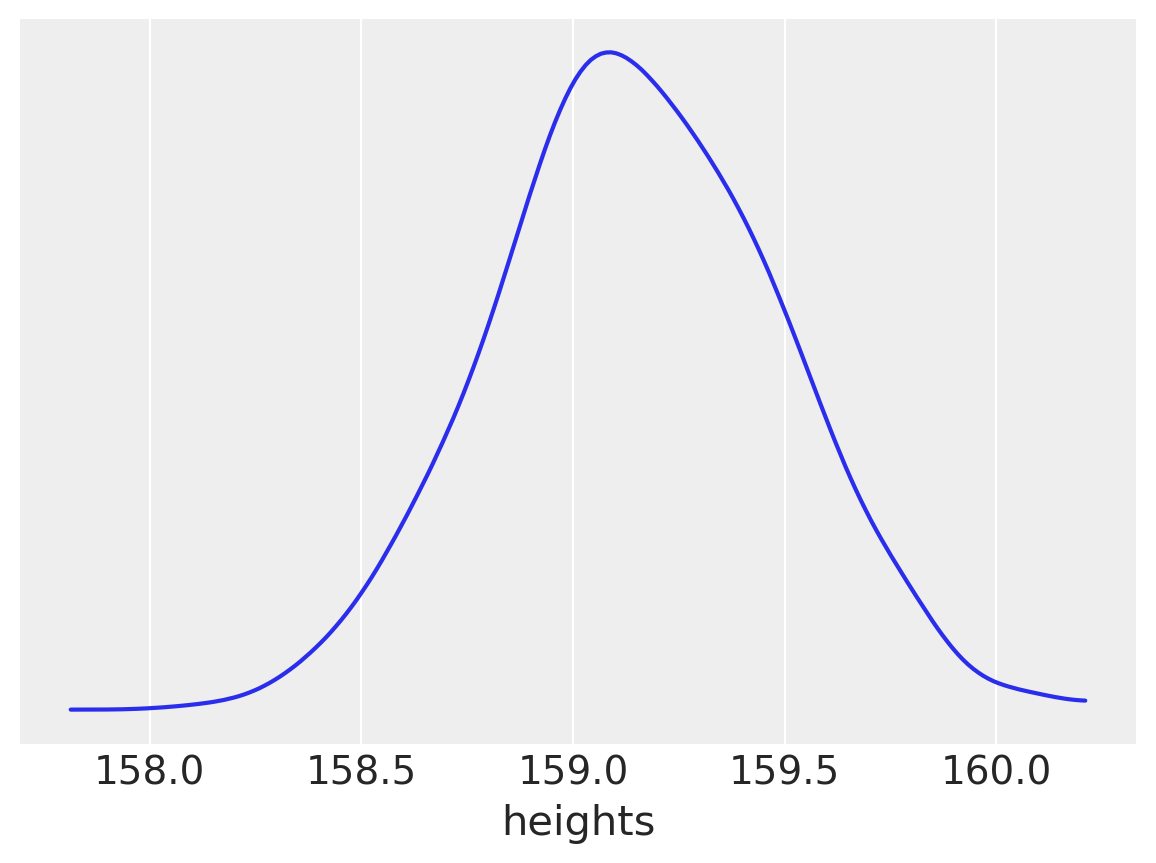

In [52]:
az.plot_kde(mu_at_50)
plt.xlabel('heights')
plt.yticks([]);

#### Code 4.52

In [53]:
az.hpd(mu_at_50)

array([158.53312792, 159.78319326])

#### Code 4.53 and 4.54

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [54]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
trace_4_3_thinned = trace_4_3[::10]
mu_pred = np.zeros((len(weight_seq), len(trace_4_3_thinned)*trace_4_3.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_4_3_thinned['a'] + \
        trace_4_3_thinned['b'] * (w - d2.weight.mean())

#### Code 4.55

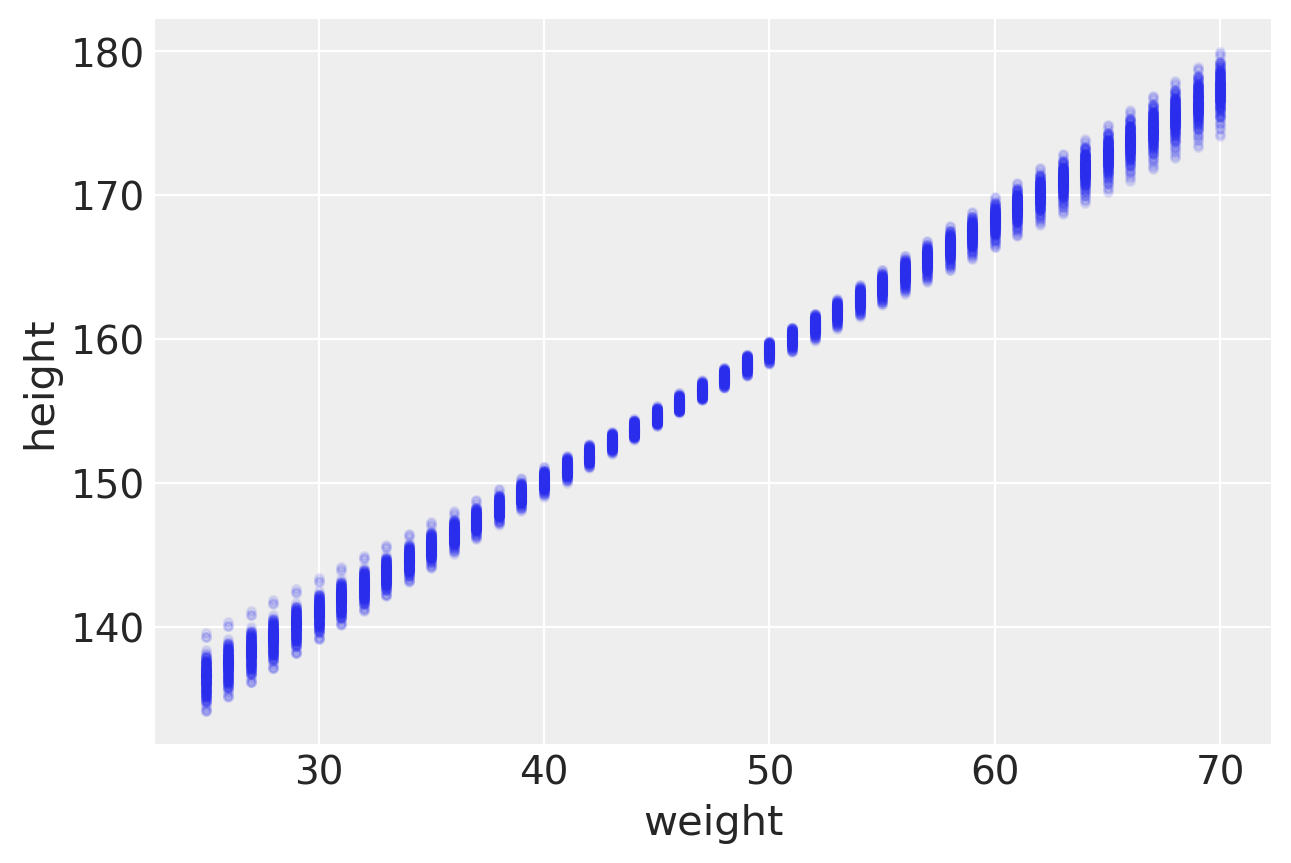

In [55]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

#### Code 4.56

In [56]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T)

#### Code 4.57

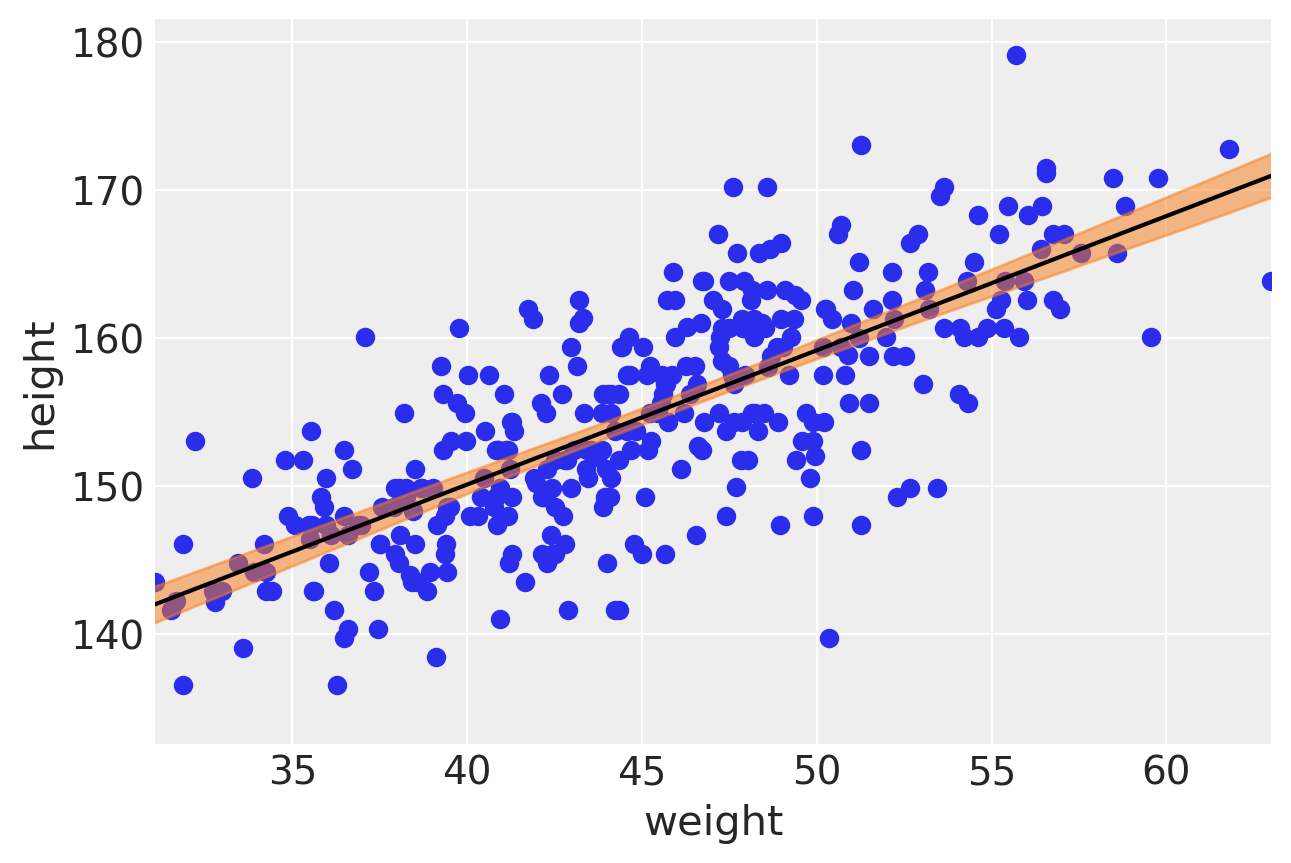

In [57]:
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.59

Now we are going to use ```sample_posterior_predictive()``` from PyCM3. This function gives us posterior predictive samples, that is for each value of the input variable we get a sample (from the posterior) of the output variable. Thus in the following example the shape of `height_pred['height'].shape is (200, 352)`

In [58]:
height_pred = pm.sample_posterior_predictive(trace_4_3, 200, m4_3)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1296: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


#### Code 4.60

In [59]:
height_pred_hpd = az.hpd(height_pred['height'])

#### Code 4.61

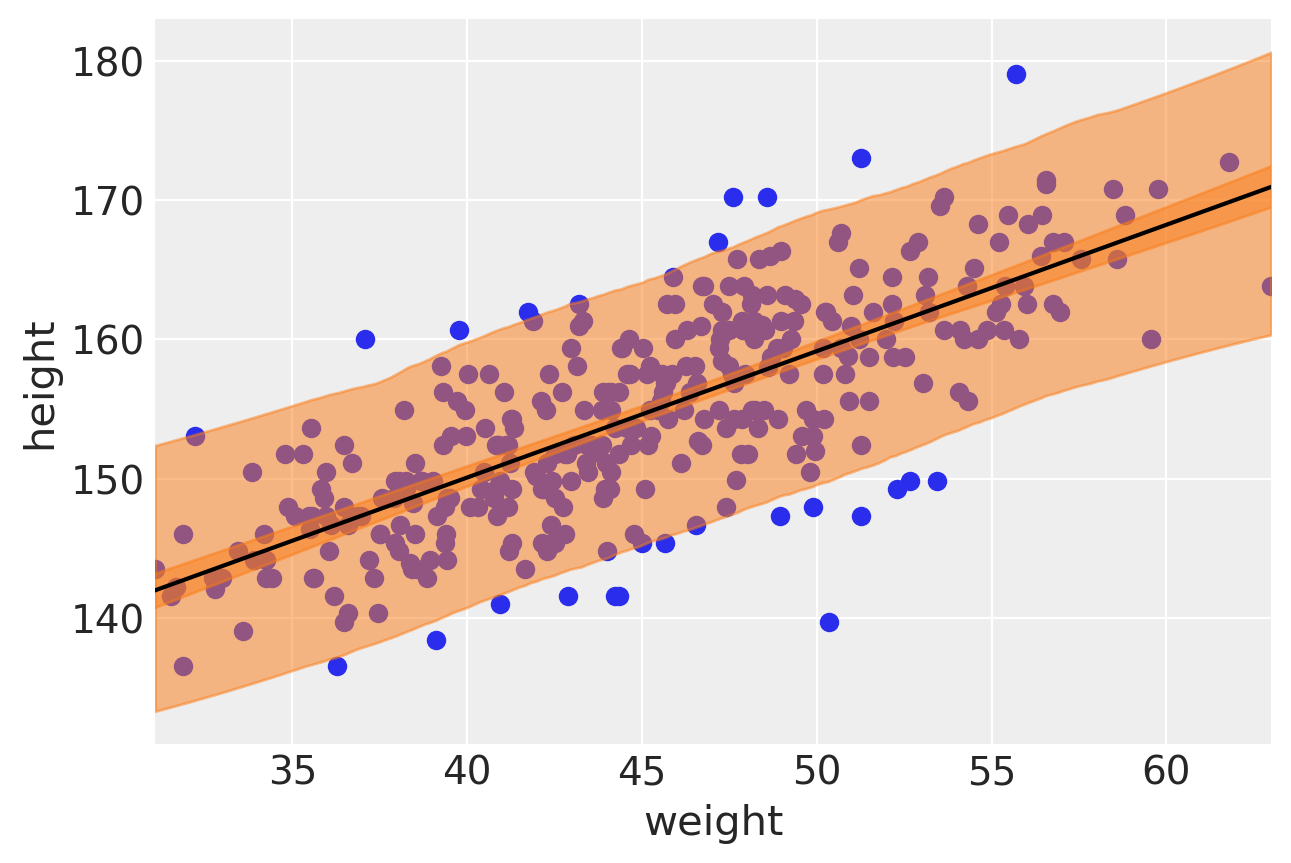

In [60]:
plt.scatter(d2.weight, d2.height)
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(d2.weight, height_pred['height'])
plt.plot(weight_seq, mu_mean, 'k')
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values.

#### Code 4.63

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weights values, called `weight_seg`.

In [61]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    i = np.random.randint(len(trace_4_3))
    mu_pr = trace_4_3['a'][i] + trace_4_3['b'][i] * \
        (weight_seq - d2.weight.mean())
    sigma_pred = trace_4_3['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

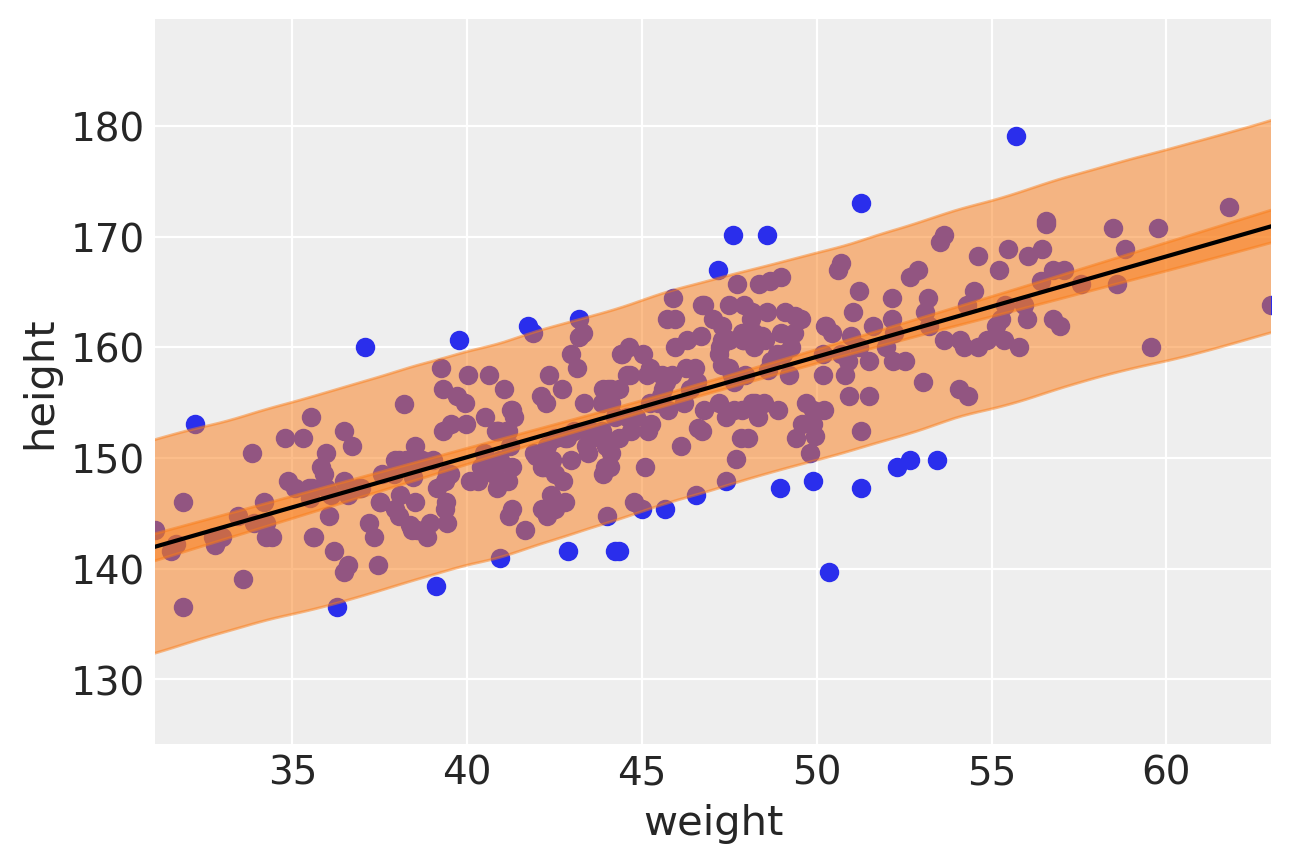

In [62]:
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(weight_seq, np.array(post_samples))
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [63]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.65

In [64]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

with pm.Model() as m_4_5:
    a = pm.Normal('a', mu=178, sd=100)
    b1 = pm.Lognormal('b1', mu=0, sd=1)
    b2 = pm.Normal('b2', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + b1 * d.weight_std + b2 * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b2, b1, a]


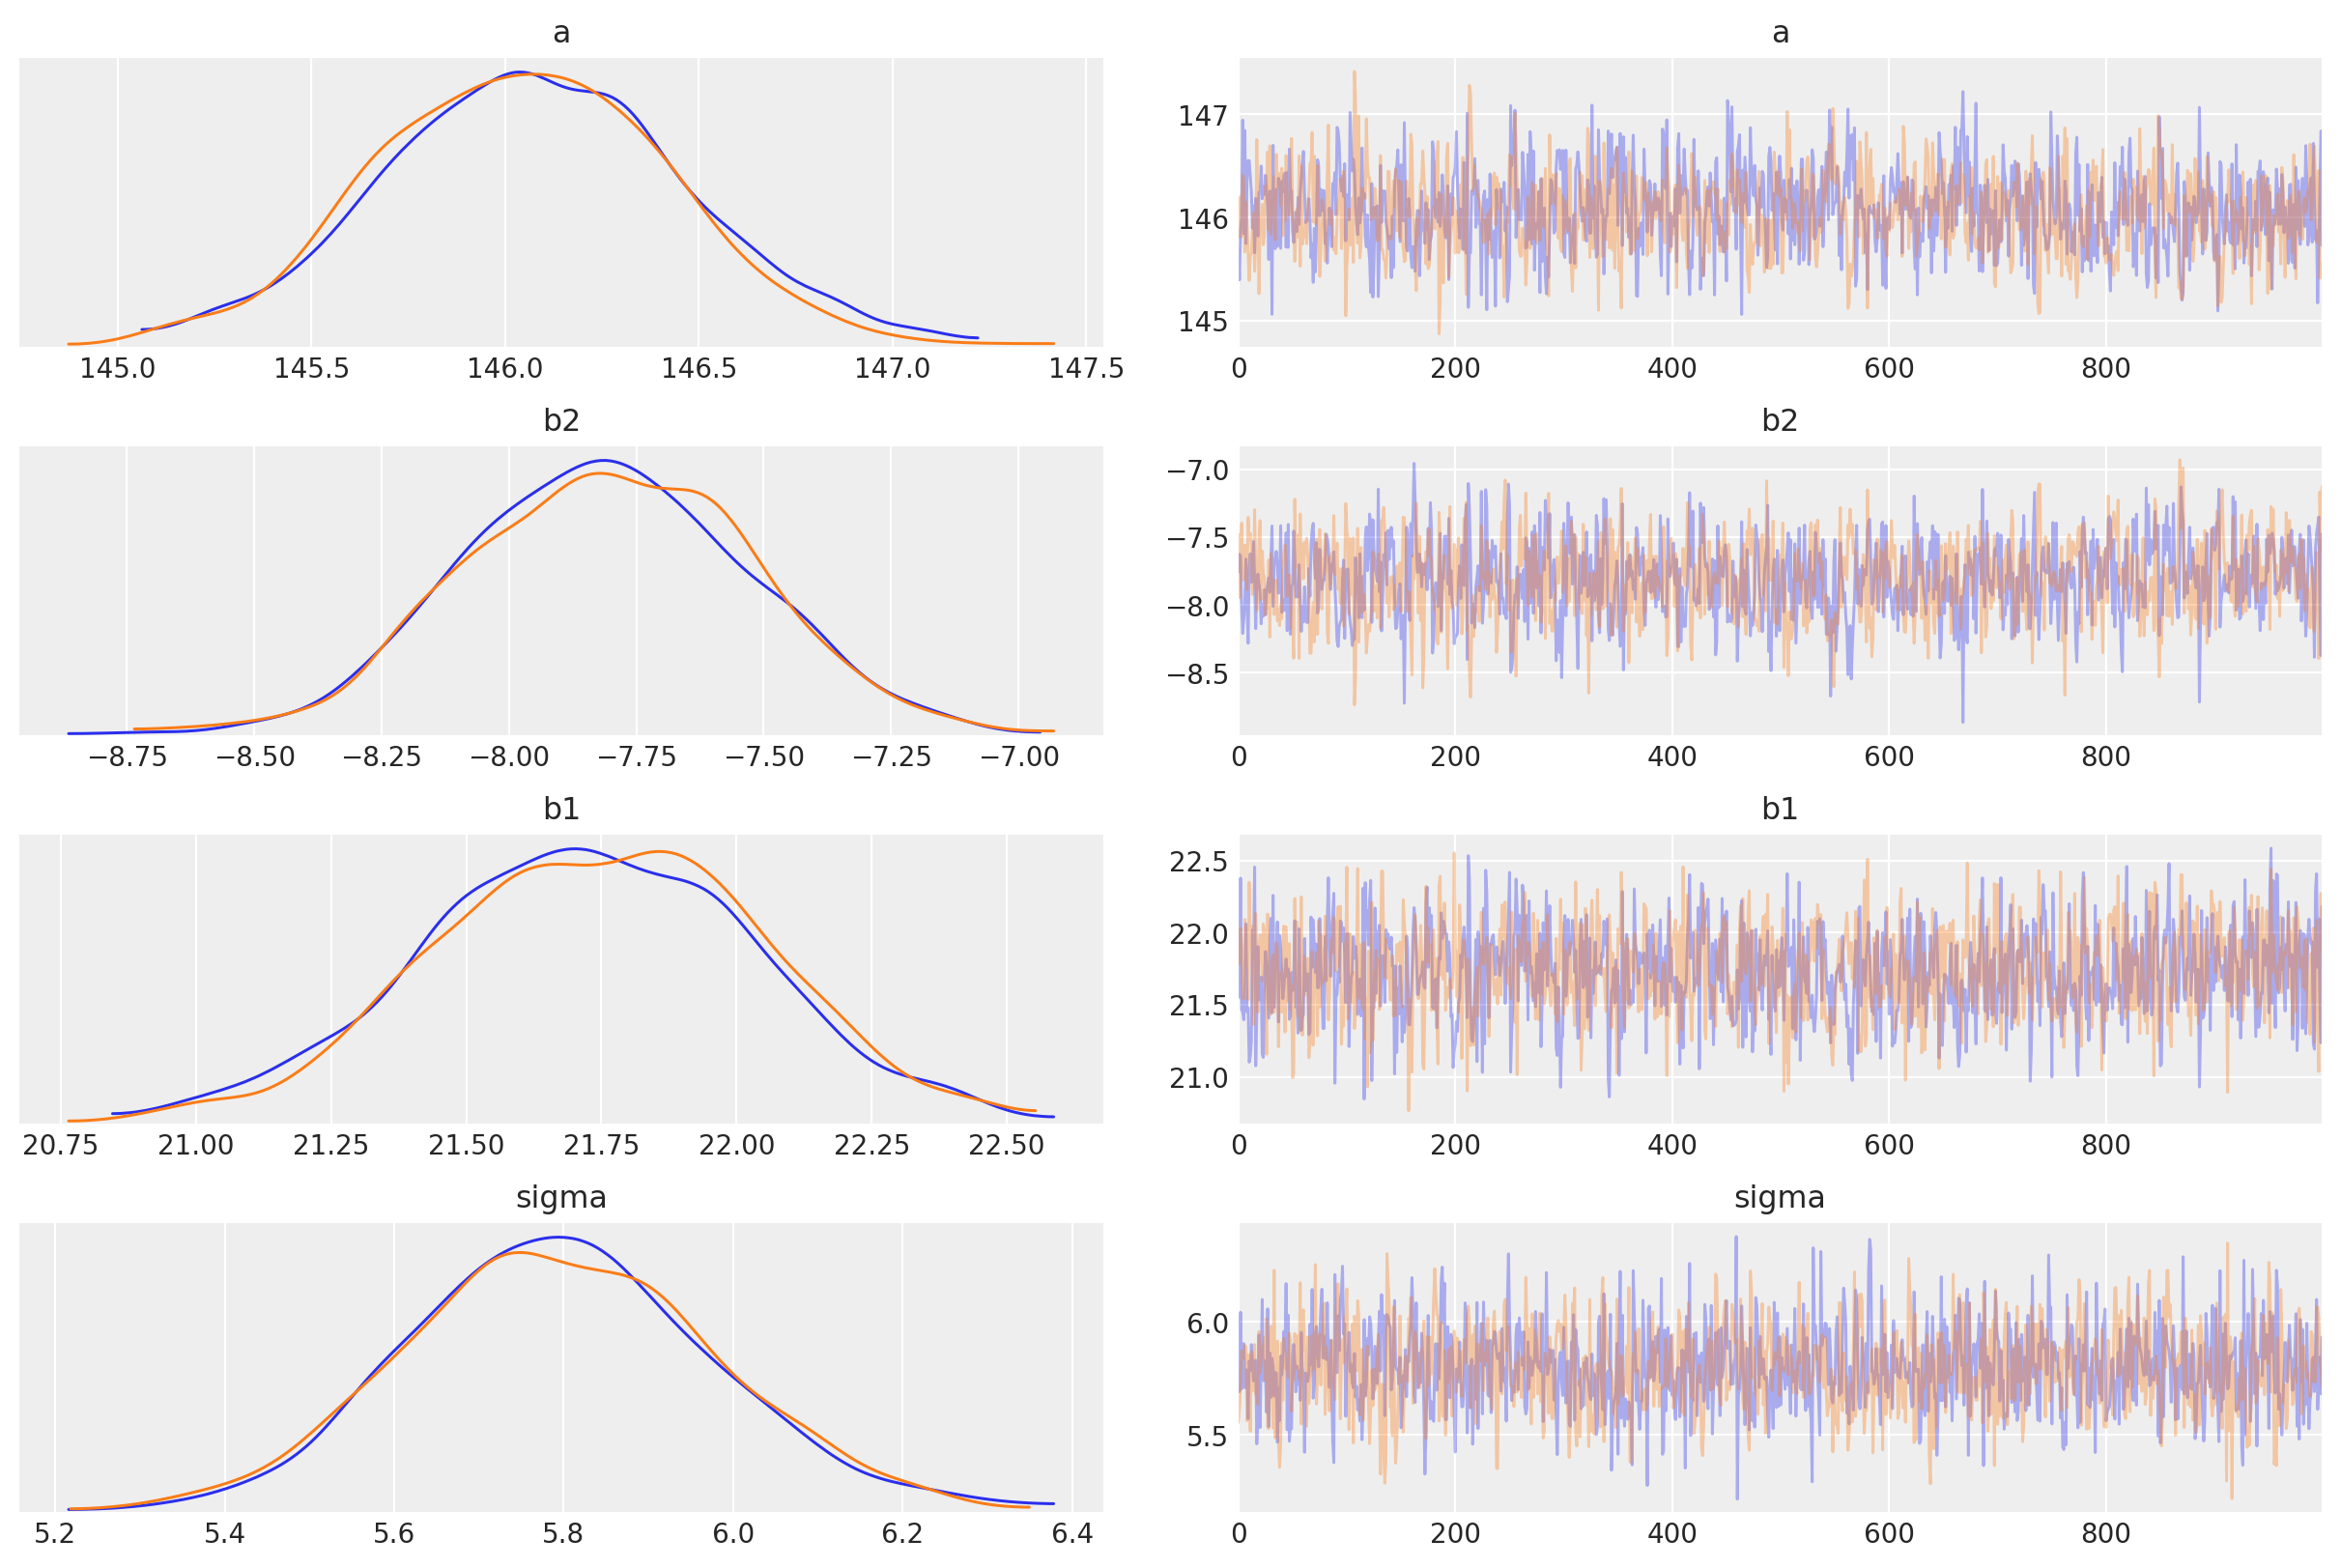

In [65]:
varnames = ['~mu']
az.plot_trace(trace_4_5, varnames);

#### Code 4.66

In [66]:
az.summary(trace_4_5, varnames, kind='stats', round_to=2)

mean    sd  hpd_3%  hpd_97%
a      146.06  0.38  145.41   146.86
b2      -7.81  0.28   -8.29    -7.27
b1      21.73  0.30   21.16    22.29
sigma    5.80  0.18    5.46     6.15

#### Code 4.67

In [67]:
mu_pred = trace_4_5['mu']
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, m_4_5)

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1296: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


#### Code 4.68

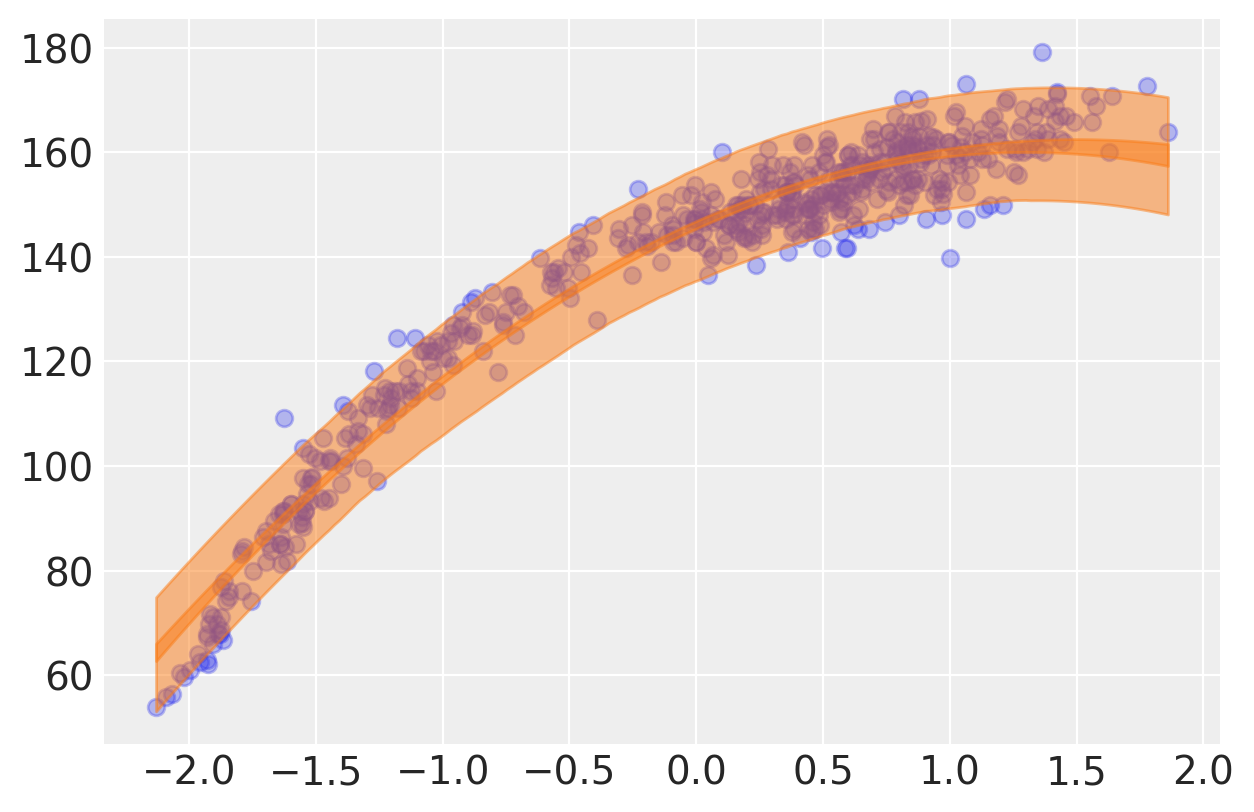

In [68]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred)
az.plot_hpd(d.weight_std, height_pred['height']);

#### Code 4.69

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [69]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [70]:
with pm.Model() as m_4_6:
    a = pm.Normal('a', mu=178, sd=100)
    b = pm.Normal('b', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', a + pm.math.dot(b, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


#### Code 4.70 and 4.71

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/sampling.py:1296: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


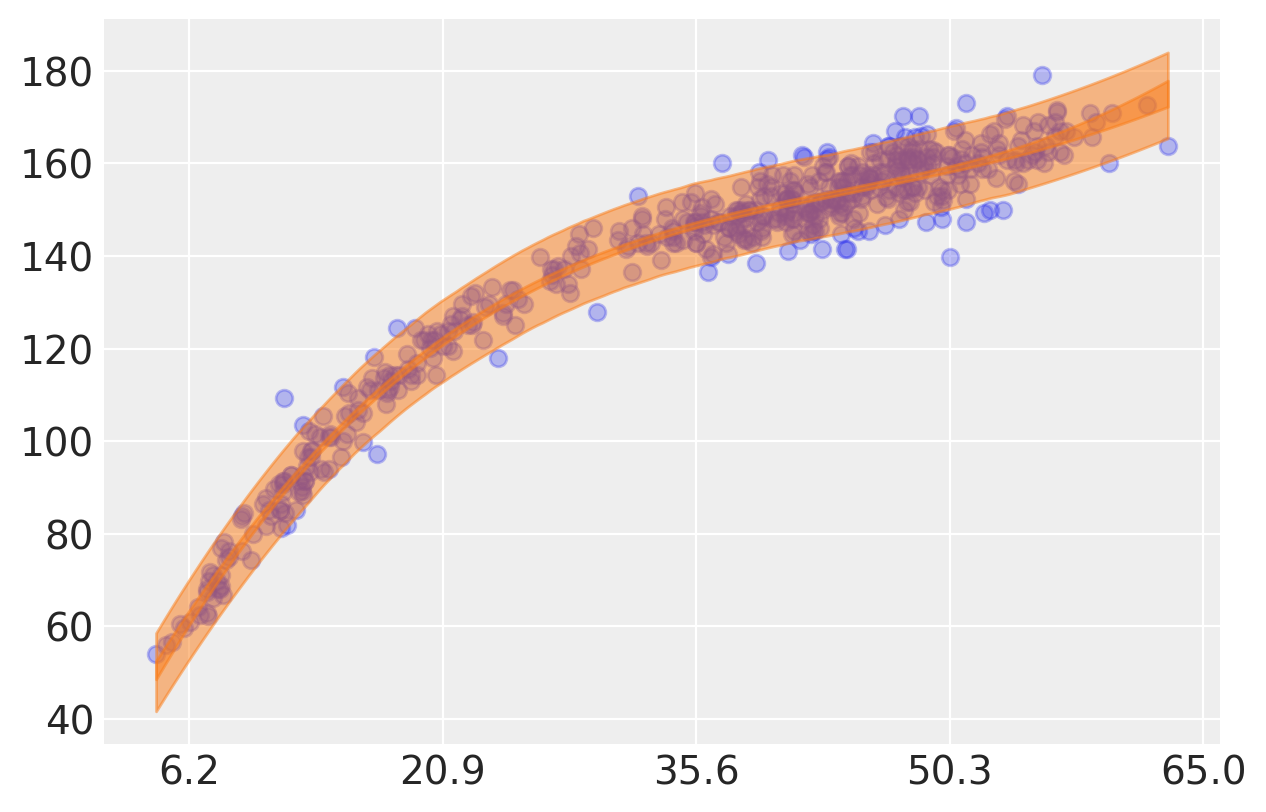

In [71]:
mu_pred = trace_4_6['mu']
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, m_4_6)

plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred)
az.plot_hpd(d.weight_std, height_pred['height'])

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

#### Code 4.72

In [72]:
d = pd.read_csv('Data/cherry_blossoms.csv')
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind='stats')

mean       sd   hpd_3%  hpd_97%
year        1533.395  291.123  1016.00  1978.00
doy          104.921    6.258    92.00   115.00
temp           6.100    0.683     4.80     7.32
temp_upper     6.938    0.812     5.56     8.40
temp_lower     5.264    0.762     3.75     6.83

#### Code 4.73

In [73]:
d2 = d.dropna(subset=['doy'])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

#### Code 4.74

Here we will use patsy as a simple way of building the b-spline matrix. For more detail please read https://patsy.readthedocs.io/en/latest/spline-regression.html

In [74]:
from patsy import dmatrix
B = dmatrix("bs(year, knots=knots, degree=3, include_intercept=True) - 1",
            {'year': d2.year.values, 'knots': knot_list[1:-1]})

#### Code 4.75

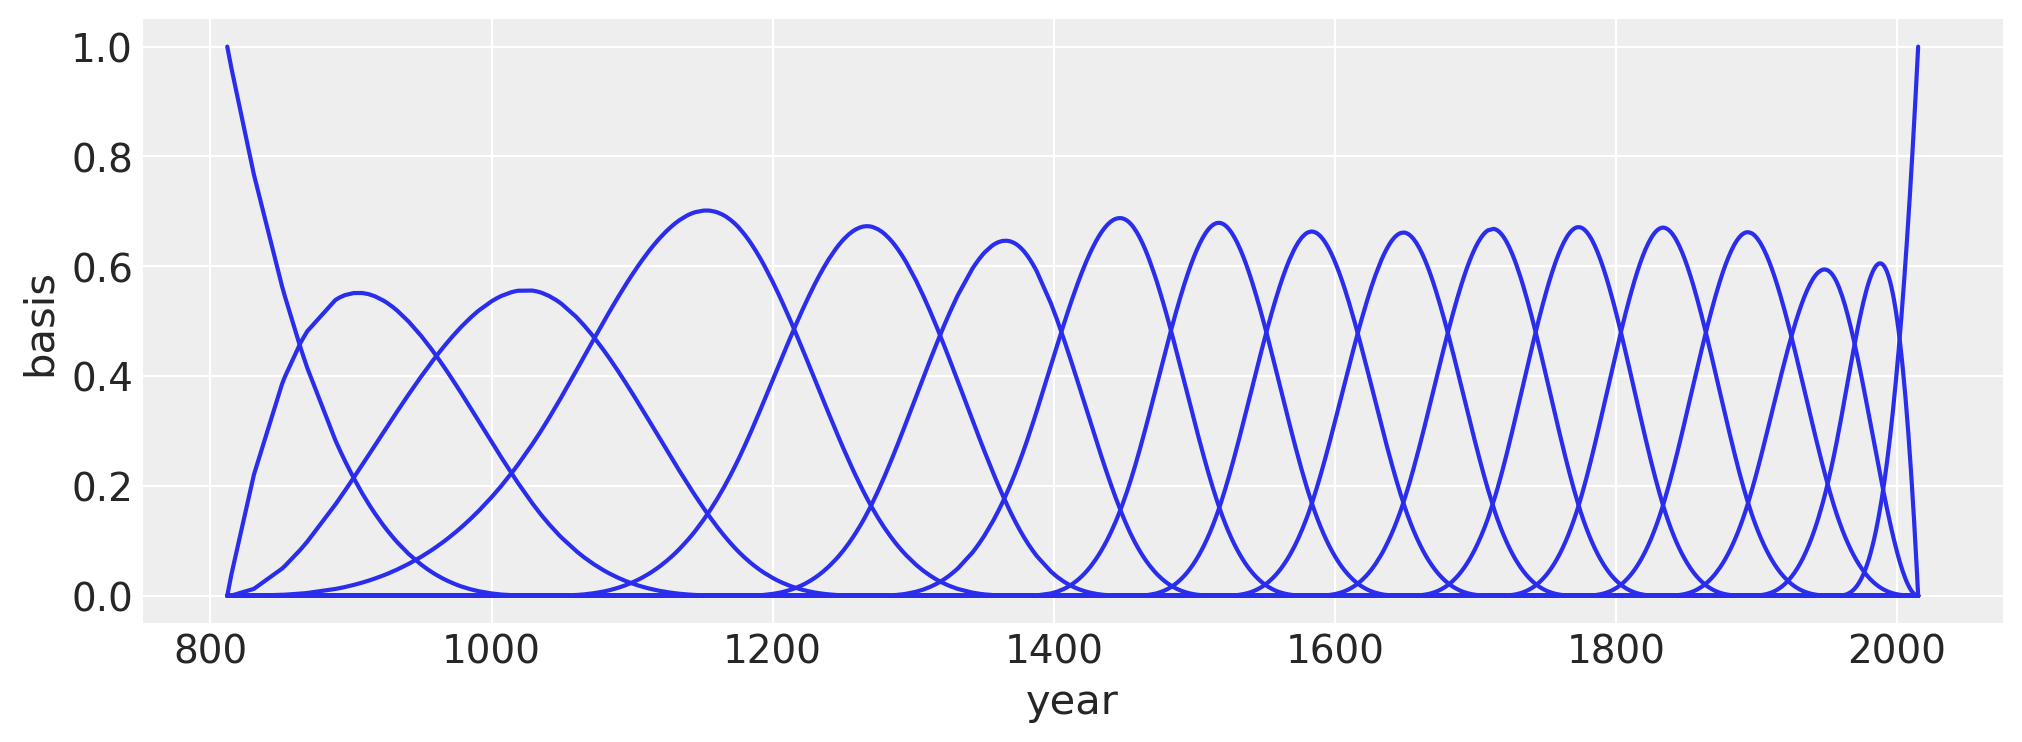

In [75]:
_, ax = plt.subplots(1, 1,  figsize=(12, 4))
for i in range(17):
    ax.plot(d2.year, (B[:, i]), color='C0')
ax.set_xlabel('year')
ax.set_ylabel('basis');

#### Code 4.76

In [76]:
with pm.Model() as m4_7:
    a = pm.Normal('a', 100, 10)
    w = pm.Normal('w', mu=0, sd=10, shape=B.shape[1])
    mu = pm.Deterministic('mu', a + pm.math.dot(np.asarray(B), w.T))
    sigma = pm.Exponential('sigma', 1)
    D = pm.Normal('D', mu, sigma, observed=d2.doy)
    trace_m4_7 = pm.sample_smc(1000)

Sample initial stage: ...
Stage:   0 Beta: 0.000 Steps:  25 Acce: 1.000
Stage:   1 Beta: 0.000 Steps:  25 Acce: 0.516
Stage:   2 Beta: 0.000 Steps:   6 Acce: 0.393
Stage:   3 Beta: 0.001 Steps:   9 Acce: 0.329
Stage:   4 Beta: 0.003 Steps:  11 Acce: 0.272
Stage:   5 Beta: 0.007 Steps:  14 Acce: 0.264
Stage:   6 Beta: 0.015 Steps:  15 Acce: 0.237
Stage:   7 Beta: 0.027 Steps:  17 Acce: 0.240
Stage:   8 Beta: 0.045 Steps:  16 Acce: 0.241
Stage:   9 Beta: 0.071 Steps:  16 Acce: 0.246
Stage:  10 Beta: 0.105 Steps:  16 Acce: 0.253
Stage:  11 Beta: 0.151 Steps:  15 Acce: 0.252
Stage:  12 Beta: 0.219 Steps:  15 Acce: 0.274
Stage:  13 Beta: 0.314 Steps:  14 Acce: 0.264
Stage:  14 Beta: 0.441 Steps:  15 Acce: 0.253
Stage:  15 Beta: 0.620 Steps:  15 Acce: 0.259
Stage:  16 Beta: 0.862 Steps:  15 Acce: 0.266
Stage:  17 Beta: 1.000 Steps:  14 Acce: 0.255


#### Code 4.77

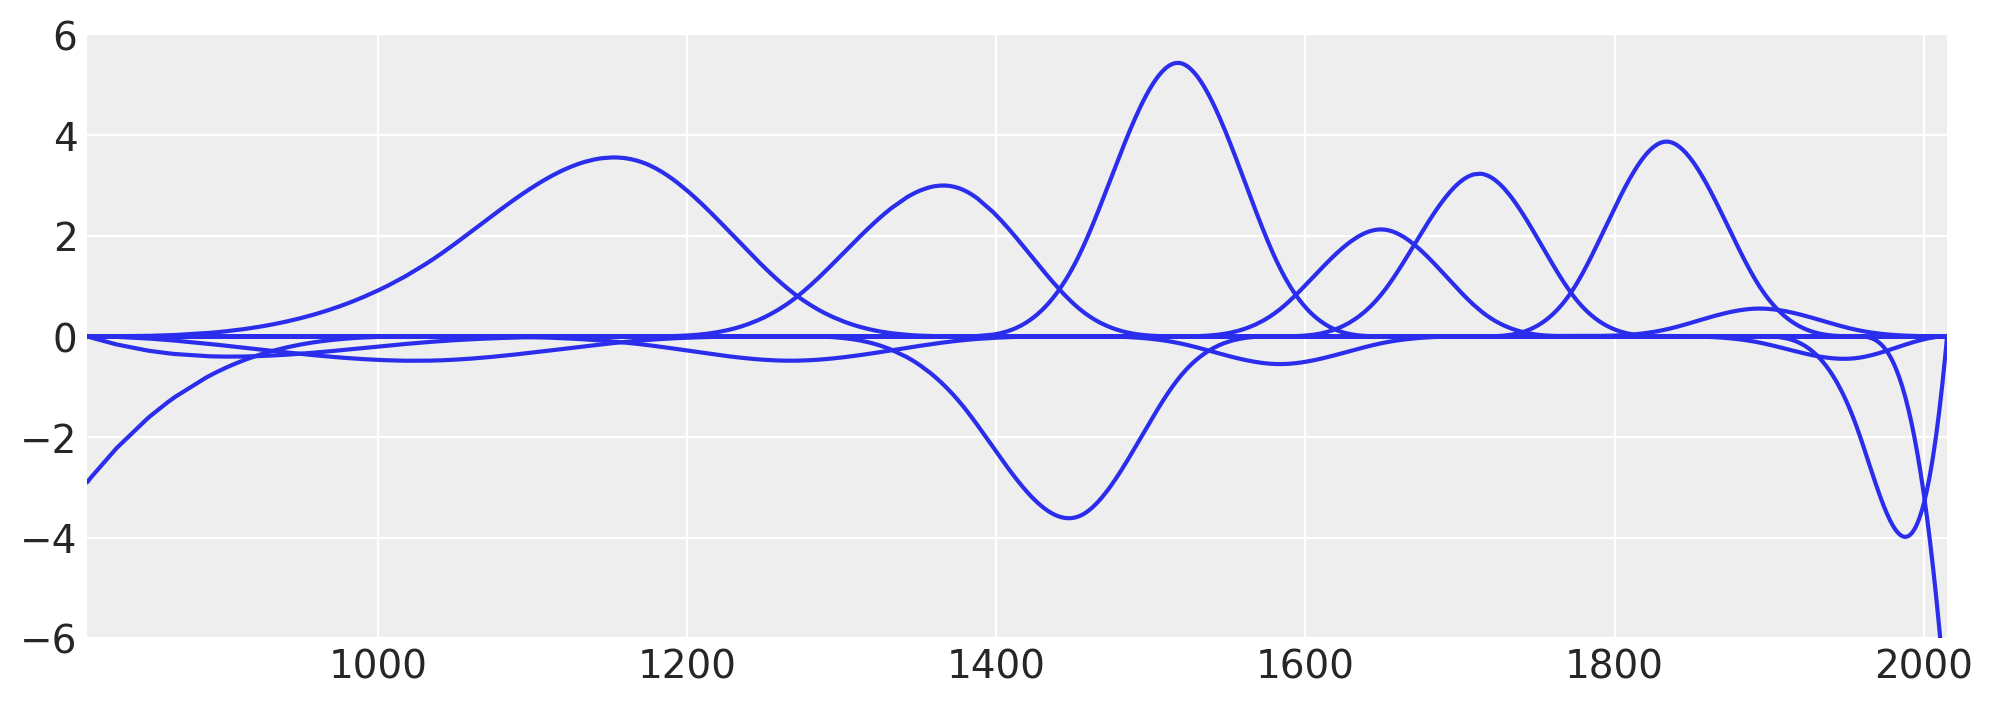

In [77]:
_, ax = plt.subplots(1, 1,  figsize=(12, 4))
wp = trace_m4_7[w].mean(0)
for i in range(17):
    ax.plot(d2.year, (wp[i]*B[:, i]), color='C0')
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

#### Code 4.78

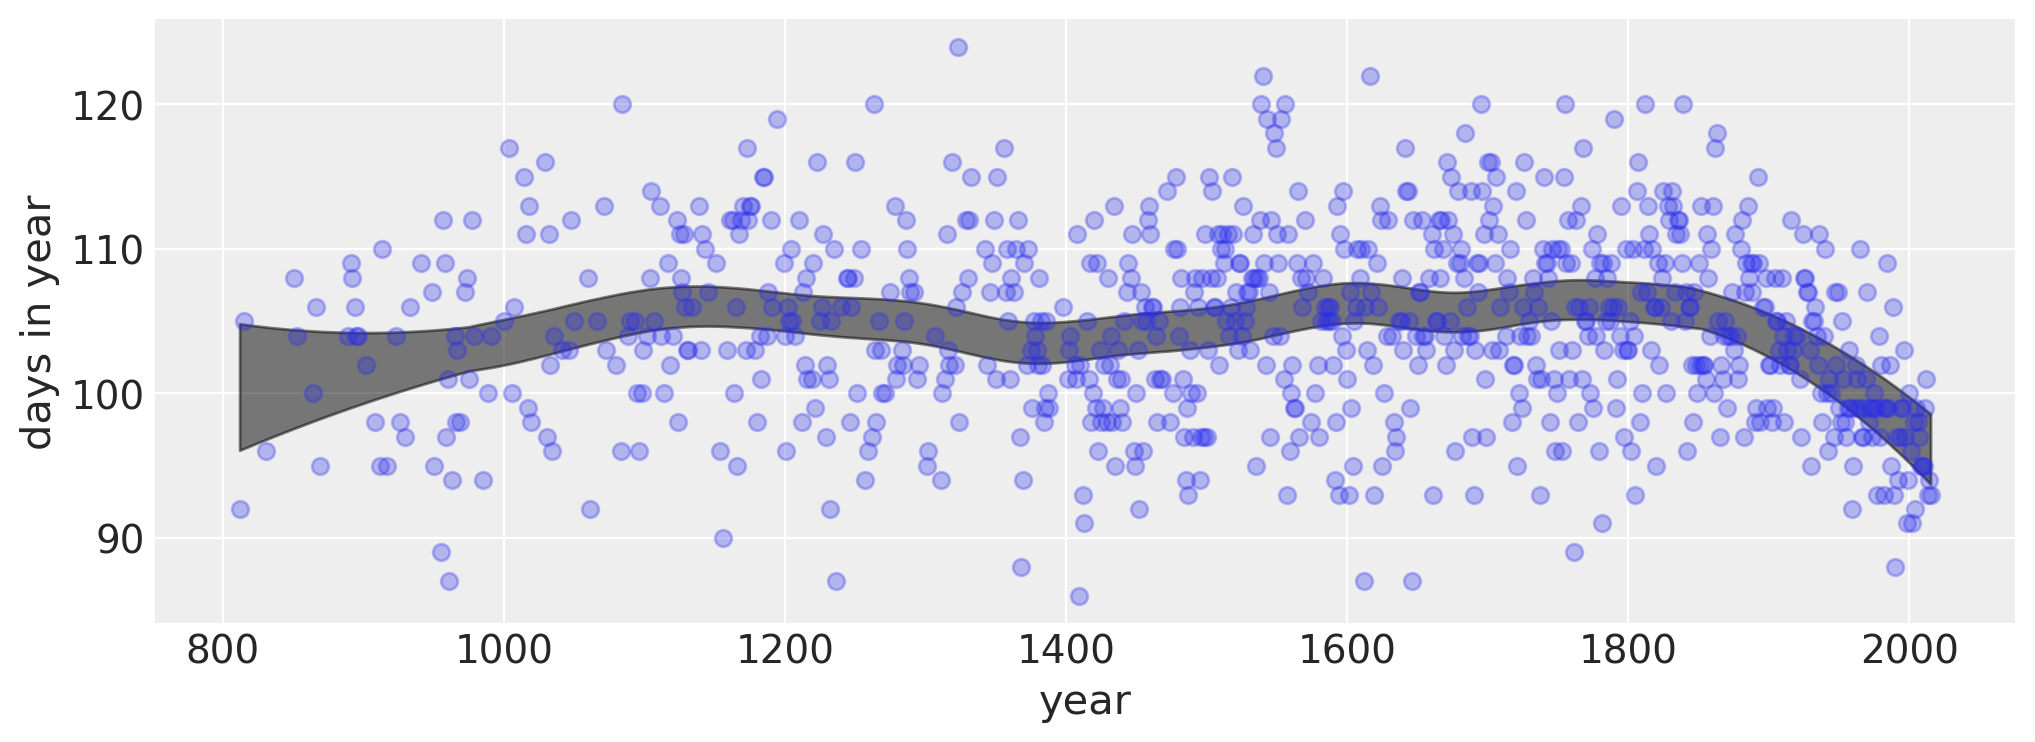

In [78]:
_, ax = plt.subplots(1, 1,  figsize=(12, 4))

ax.plot(d2.year, d2.doy, 'o', alpha=0.3)
az.plot_hpd(d2.year, trace_m4_7['mu'], color='k')
ax.set_xlabel('year')
ax.set_ylabel('days in year');

In [79]:
%watermark -n -u -v -iv -w

pymc3    3.8
autopep8 1.4.4
json     2.0.9
pandas   0.25.3
numpy    1.17.4
arviz    0.6.1
last updated: Mon Jan 13 2020 

CPython 3.7.3
IPython 7.11.1
watermark 2.0.2
